In [1]:
def train_and_submit(train_70, train_30, test, feats, global_min, 
                     model, params,
                     file_sufix= '', opis='', subfolder='', 
                     learning_curve = False, add_model_column_min = -1, total = None,  
                     save_min=7000, kaggle_min=-1):
    import pandas as pd
    import numpy as np
    from datetime import datetime
    from sklearn.metrics import r2_score, mean_absolute_error
    from scikitplot.estimators import plot_learning_curve

    train_70[feats]
    train_30[feats]
    test[['car_id', *feats]]

    
    time_model_start = datetime.now().strftime("%H:%M:%S")
    
    X_train = train_70[ feats ].values
    y_train = train_70['price_value'].values
    y_train_log = np.log(y_train)

    if params is not None: 
        model = model(**params)
    model.fit(X_train, y_train_log)

    ## check 
    y_train_pred_log = model.predict(train_30[ feats ].values)
    y_train_pred = np.exp(y_train_pred_log)
    y_train_pred[ y_train_pred < global_min] = global_min
    y_train_pred

    mae = mean_absolute_error(train_30['price_value'].values, y_train_pred)
    r2 = r2_score(train_30['price_value'].values, y_train_pred)
    print(f'mea: {mae}')
    print(f'r2: {r2}')

    ## add_model_column
    model_cl = 'model_' + type(model).__name__ + "_{:.5f}_".format(mae).replace('.', '_') + file_sufix
    if mae <= add_model_column_min and total is not None: 
        X_total = total[feats].values
        y_pred_log = model.predict(X_total)
        y_pred = np.exp(y_pred_log)
        y_pred[ y_pred < global_min] = global_min
        total[model_cl] = y_pred

    learning_curve_plot = None
    if learning_curve: 
        print("Learning curve for: " + type(model).__name__)
        learning_curve_plot = plot_learning_curve(model, X_train, y_train, cv=3, random_state=0, shuffle=True)

    time_model_end = datetime.now().strftime("%H:%M:%S")

    try:
        if mae <= save_min:
            save_model(file_sufix, subfolder, test, feats, global_min, 
                       model, mae, r2,
                       details = {"mean_absolute_error" : mae, "r2_score" : r2, 
                                  "vars": ("'"+ "', '".join(list(feats))+"'"), 
                                  "best_params" : params,
                                  "model_start" : time_model_start, "model_end" : time_model_end, 
                                  "opis" : opis}, 
                       learning_curve_plot = learning_curve_plot if learning_curve else None, hist_plt=None,
                       kaggle=(mae < kaggle_min))
    except: 
        print('Error on save!')
        
    return mae, r2, model, model_cl, learning_curve_plot

def save_model(file_sufix, subfolder, test, feats, global_min, model, mae=0.0, r2=0.0,
               details='', learning_curve_plot=None, hist_plt=None, kaggle=None):
    
    from kaggle.api.kaggle_api_extended import KaggleApi
    kaggle_api = KaggleApi()
    kaggle_api.authenticate()
    
    import json
    import pandas as pd
    import numpy as np

    test['car_id']
    
    ## predict test
    X_test = test[feats].values
    y_pred_log = model.predict(X_test)
    y_pred = np.exp(y_pred_log)
    y_pred[ y_pred < global_min] = global_min
    test['price_value'] = y_pred
#     result = pd.concat([test['car_id'], y_pred], axis=1)
#     result = test['car_id']
#     result['price_value'] = y_pred

    
    file_name = 'output_model/' + subfolder + '/' \
        + ('' if mae==0.0 else "mae_{:.5f}_".format(mae).replace('.', '_')) \
        + ('' if r2==0.0 else "r2_{:.5f}_".format(r2).replace('.', '_')) \
        + type(model).__name__ + '_' \
        + file_sufix + '.csv'
        
    test[['car_id','price_value']].to_csv(file_name, index=False)
#     test = test.drop(['price_value_log', 'price_value_pln_log_transl','price_value_pln','price_value'],
#                            axis=1, errors='ignore')

    message = json.dumps(details, ensure_ascii=False, indent=4)
    with open(file_name.replace('.csv','.txt'), 'w') as outfile: 
        outfile.write(message)
    
    if learning_curve_plot is not None:
        learning_curve_plot.get_figure().savefig(file_name.replace('.csv','_lc.png'), bbox_inches='tight')

    if hist_plt is not None:
        hist_plt.savefig(file_name.replace('.csv','_hist.png'), bbox_inches='tight')

    if kaggle and details is not None:
        print(message)
        kaggle_api.competition_submit(file_name.replace('~/pml7/konkurs/', ''), message, 'dw-car-price-prediction')
        leaderboard = kaggle_api.competition_view_leaderboard('dw-car-price-prediction')
        print(pd.DataFrame(leaderboard['submissions'])[['teamName', 'submissionDate', 'score']].head())


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cat(df, var):
    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title('Histogram')
    sns.countplot(df[var], palette=("cubehelix"))

    plt.subplot(1,2,2)
    plt.title(var + ' vs Price')
    sns.boxplot(x=df[var], y=df['price_value_log'], palette=("cubehelix"))

    plt.show()

def print_plots_by_type(total, type = [np.object, bool], min_c = 9.0, max_c = 100., max_values=30): 
    index = 0
    for cl in total.columns[2:]:
        index += 1
        if total[cl].dtype in type:
            rows = len(total.index)
            nas = rows - total[cl].isna().sum()
            nas_perc = nas/rows*100
            values = len(total[cl].value_counts())
            print(str(index) + ': ' + cl + " [{:.2f}%=".format(nas_perc) + str(nas) + '/' + str(rows) + ' #' + str(values) + ']: ')
            if max_c >= nas_perc >= min_c: 
                if 1 < values < max_values:
                    print(total[cl].value_counts())
                    plot_cat(total, cl)
                    plt.clf()
                    plt.cla()
                    plt.close()


In [3]:
from mozo import compare_and_combine_2, Diff, merge_with_features, num_to_range_categories
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb

from scipy import stats
import math 
import datetime 

from sklearn.metrics import r2_score, mean_absolute_error


In [4]:
total = pd.read_csv('~/pml7/konkurs/output/newest_total_20201030_16_24.h5.csv')
total.info(verbose=True)

/home/conda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,86,161) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 199 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   breadcrumb                                          object 
 1   created_at                                          object 
 2   price_currency                                      object 
 3   price_details                                       object 
 4   price_value                                         float64
 5   seller_address                                      object 
 6   seller_name                                         object 
 7   seller_type                                         object 
 8   feature_czujniki_parkowania_przednie                bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana        bool   
 10  feature_kurtyny_powietrzne                          bool   
 11  feature_klimatyzacja_dwustrefowa      

1: price_currency [100.00%=160616/160616]: 
PLN    160288
EUR       328
Name: price_currency, dtype: int64


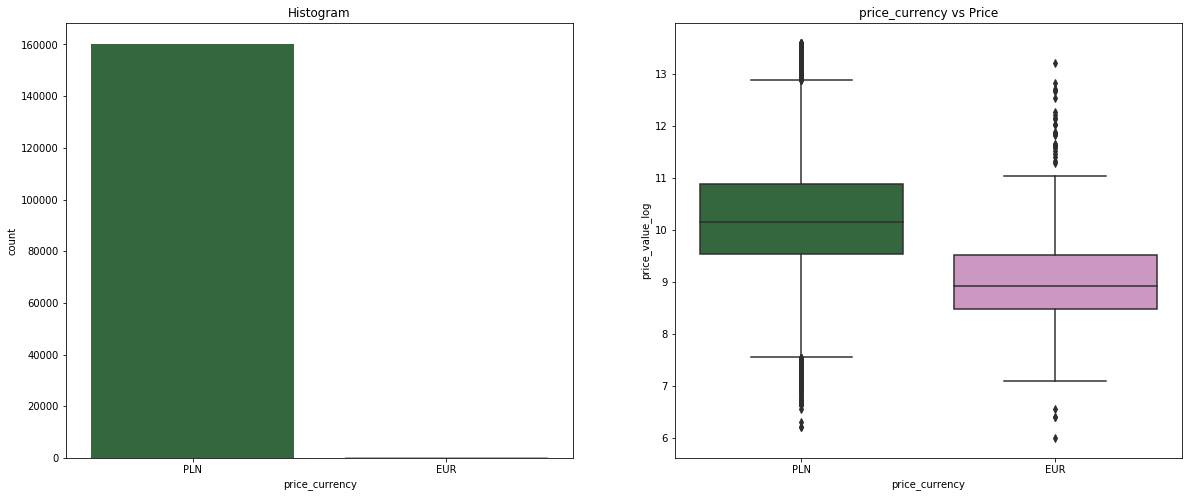

2: price_details [66.30%=106494/160616]: 
Cena Brutto, Do negocjacji                                                    49422
Cena Brutto                                                                   29148
Cena Brutto, Faktura VAT                                                      13781
Cena Brutto, Do negocjacji, Faktura VAT                                        7528
Cena Netto, Faktura VAT                                                        2828
Cena Netto, Do negocjacji, Faktura VAT                                         2277
Cena Netto                                                                      716
Cena Netto, Do negocjacji                                                       685
Brutto                                        , Do negocjacji                    51
Brutto                                                                           27
Brutto                    , Faktura VAT                    , Do negocjacji       10
Brutto                    , Faktur

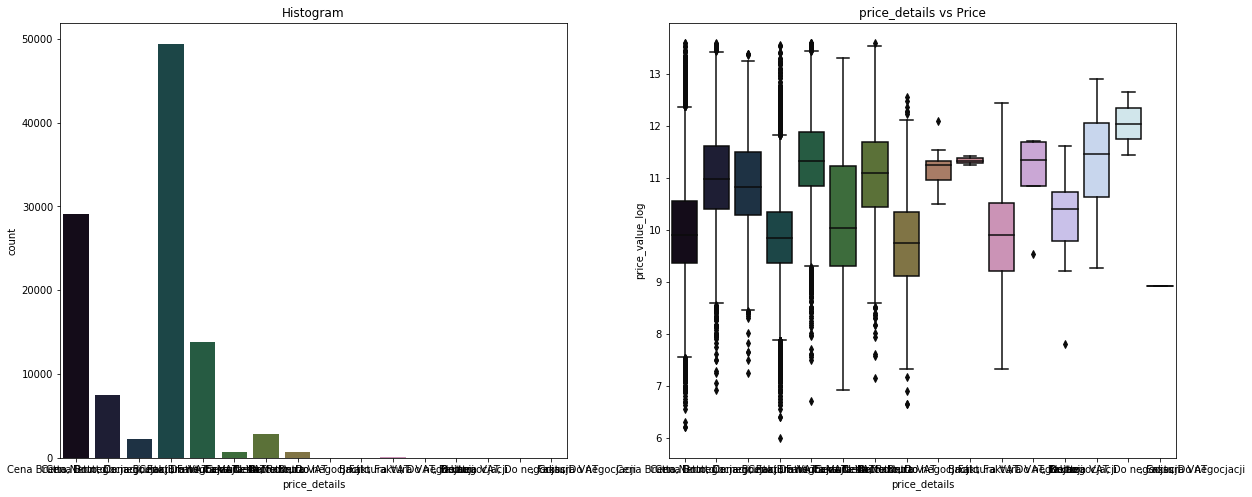

4: seller_address [99.90%=160455/160616]: 
5: seller_name [60.53%=97228/160616]: 
6: seller_type [99.90%=160455/160616]: 
Dealer            97228
Osoba prywatna    63227
Name: seller_type, dtype: int64


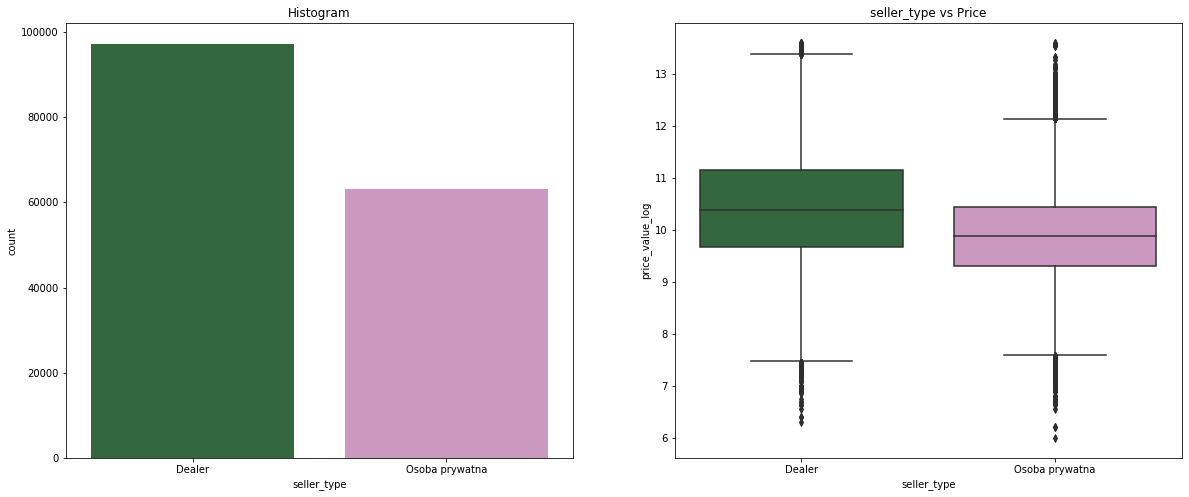

78: param_vin [22.23%=35701/160616]: 
81: param_kategoria [99.90%=160455/160616]: 
83: param_wartość_wykupu [0.25%=407/160616]: 
85: param_liczba_pozostałych_rat [0.28%=442/160616]: 
86: param_oferta_od [99.90%=160455/160616]: 
Firmy              97223
Osoby prywatnej    63232
Name: param_oferta_od, dtype: int64


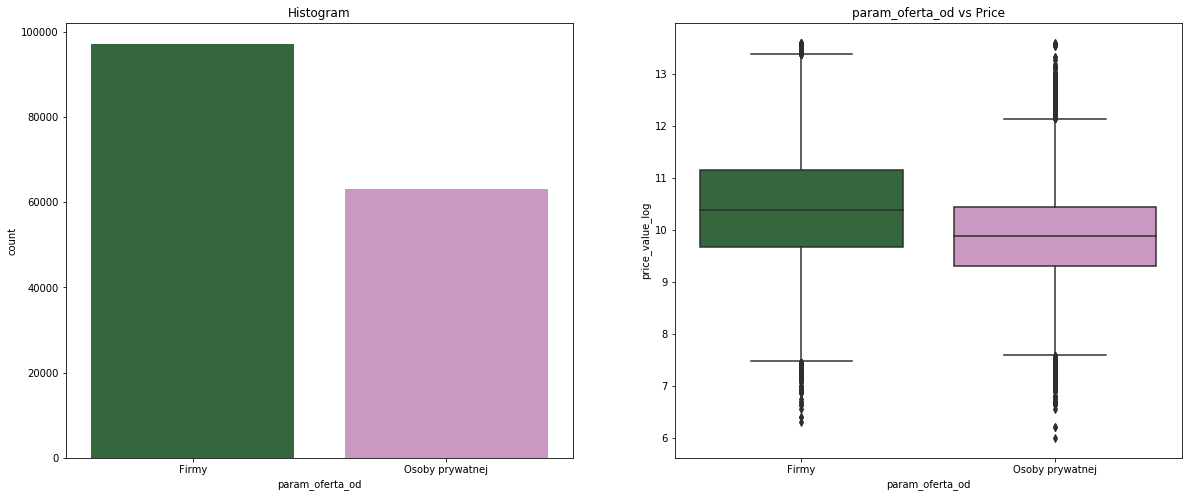

87: param_opłata_początkowa [0.26%=412/160616]: 
91: param_stan [99.90%=160455/160616]: 
Używane    146217
Nowe        14238
Name: param_stan, dtype: int64


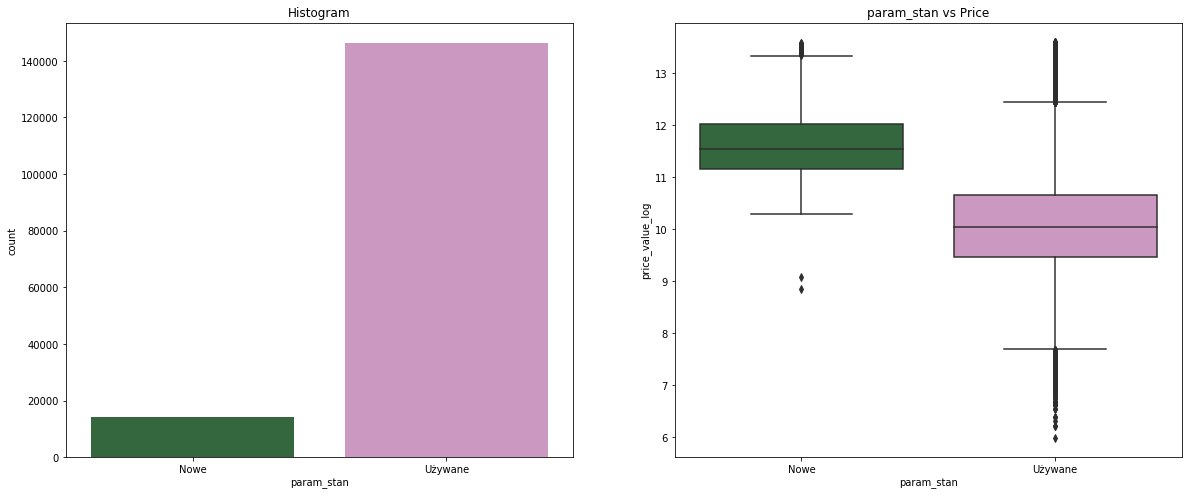

104: param_marka_pojazdu [99.90%=160455/160616]: 
105: param_model_pojazdu [99.90%=160455/160616]: 
106: param_kod_silnika [10.75%=17265/160616]: 
108: param_pierwsza_rejestracja [36.28%=58276/160616]: 
109: param_kraj_pochodzenia [68.01%=109232/160616]: 
110: param_skrzynia_biegów [94.56%=151871/160616]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów, dtype: int64


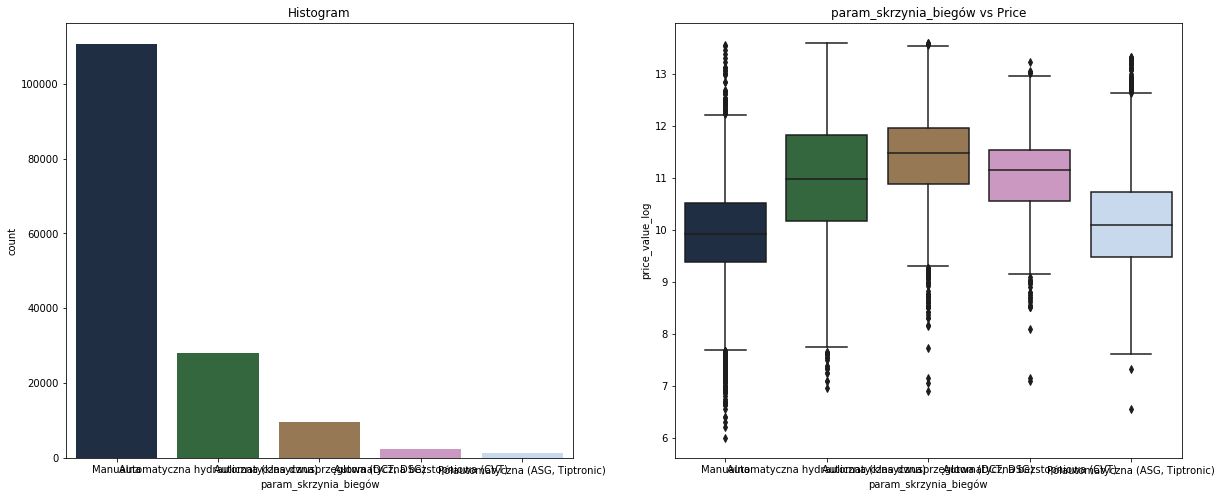

112: param_kolor [99.90%=160455/160616]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
Name: param_kolor, dtype: int64


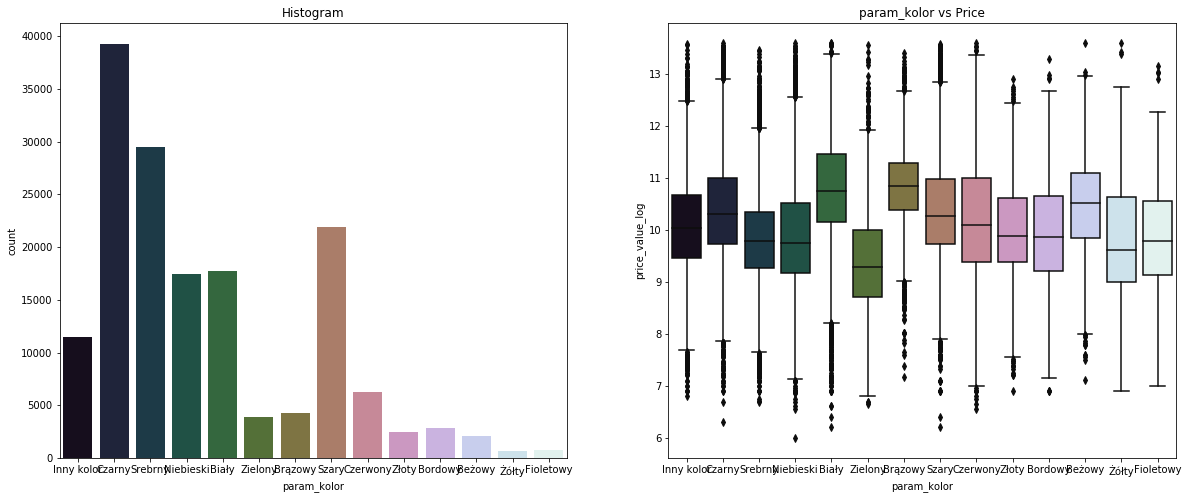

118: param_napęd [84.68%=136003/160616]: 
Na przednie koła                 99630
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd, dtype: int64


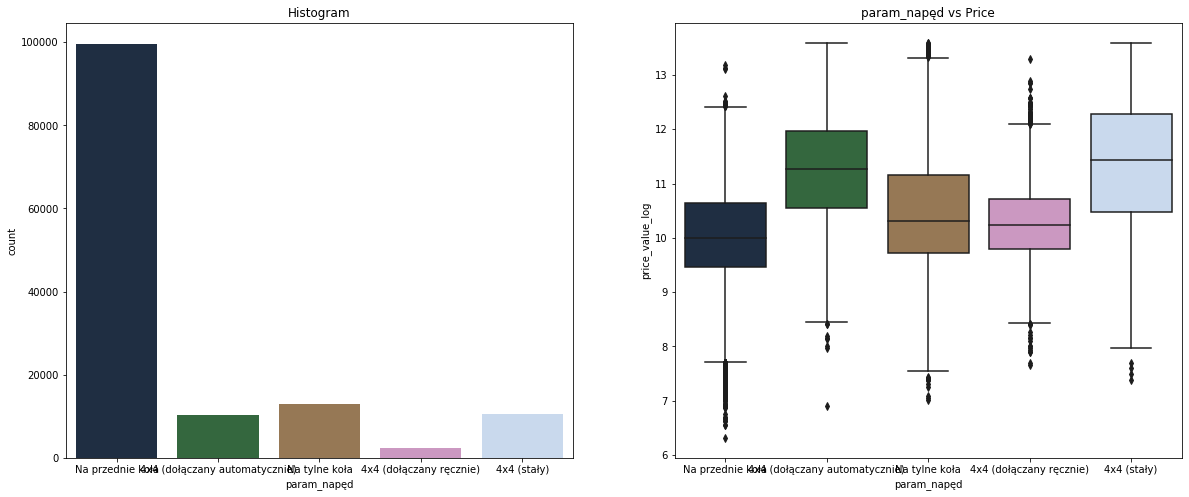

120: param_rodzaj_paliwa [99.90%=160455/160616]: 
Diesel         81448
Benzyna        70631
Benzyna+LPG     7187
Hybryda          960
Elektryczny      125
Benzyna+CNG      102
Etanol             1
Wodór              1
Name: param_rodzaj_paliwa, dtype: int64


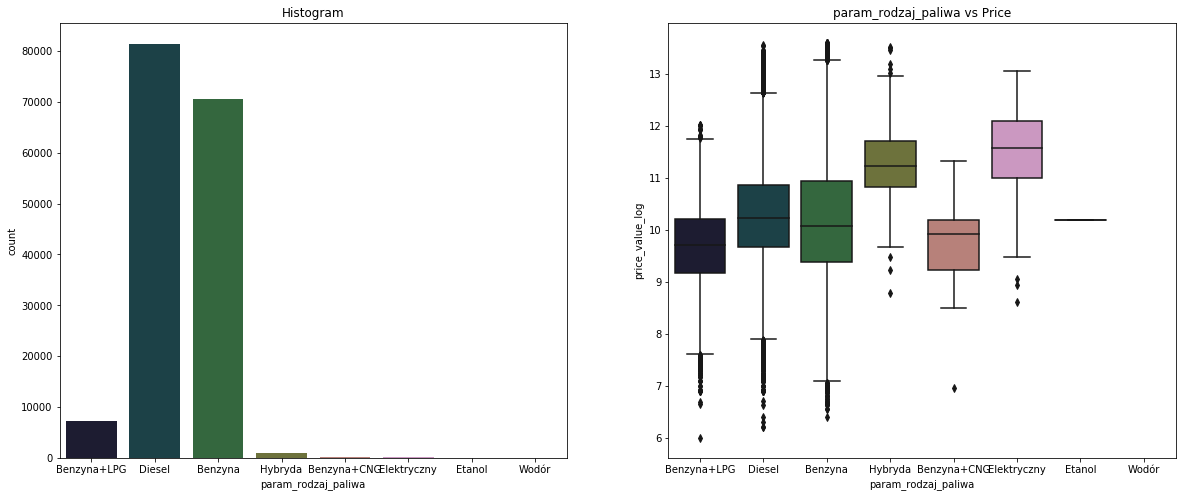

121: param_typ [99.90%=160454/160616]: 
Kombi                   33012
Sedan                   27051
Kompakt                 24864
SUV                     24263
Auta miejskie           20532
Minivan                 19784
Auta małe                5407
Coupe                    4011
Kabriolet                1348
sedan/coupe/cabrio         45
hatchback                  43
sedan/coupe                40
coupe/cabrio               37
minivan/city-car            6
city-car/suv                3
compact/minivan             3
coupe/cabrio/minivan        2
others                      1
not enough details          1
compact/sedan               1
Name: param_typ, dtype: int64


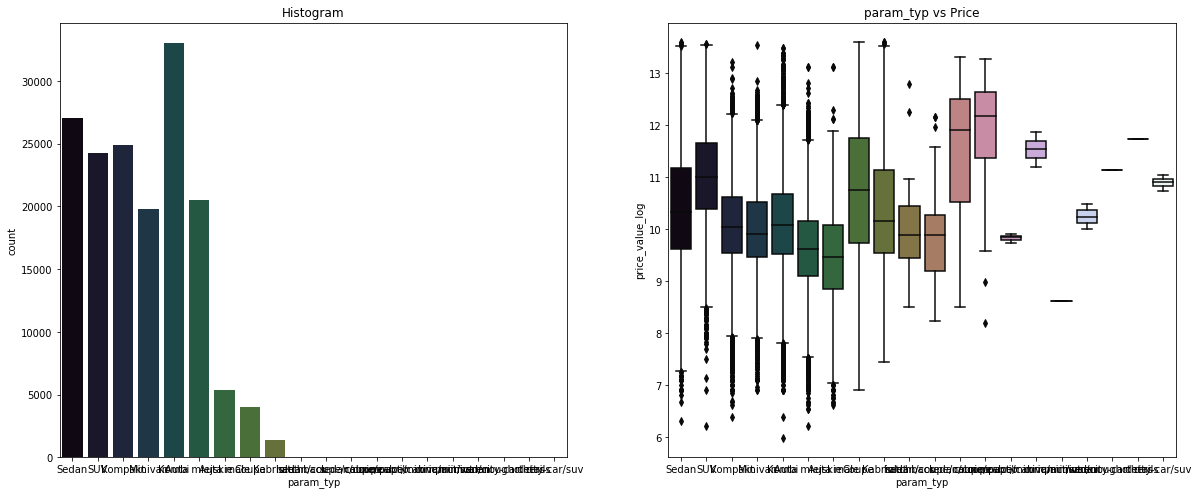

122: param_emisja_co2 [1.94%=3117/160616]: 
130: param_miesięczna_rata [0.45%=727/160616]: 
131: param_wersja [77.49%=124457/160616]: 
160: new_cat_price_value [66.30%=106494/160616]: 
perc_65    5698
perc_40    5665
perc_15    5446
perc_80    5404
perc_50    5370
perc_20    5357
perc_70    5354
perc_90    5340
perc_10    5339
perc_85    5338
perc_95    5328
perc_25    5310
perc_30    5282
perc_05    5280
perc_45    5245
perc_75    5242
perc_60    5217
perc_00    5201
perc_35    5041
perc_55    5037
Name: new_cat_price_value, dtype: int64


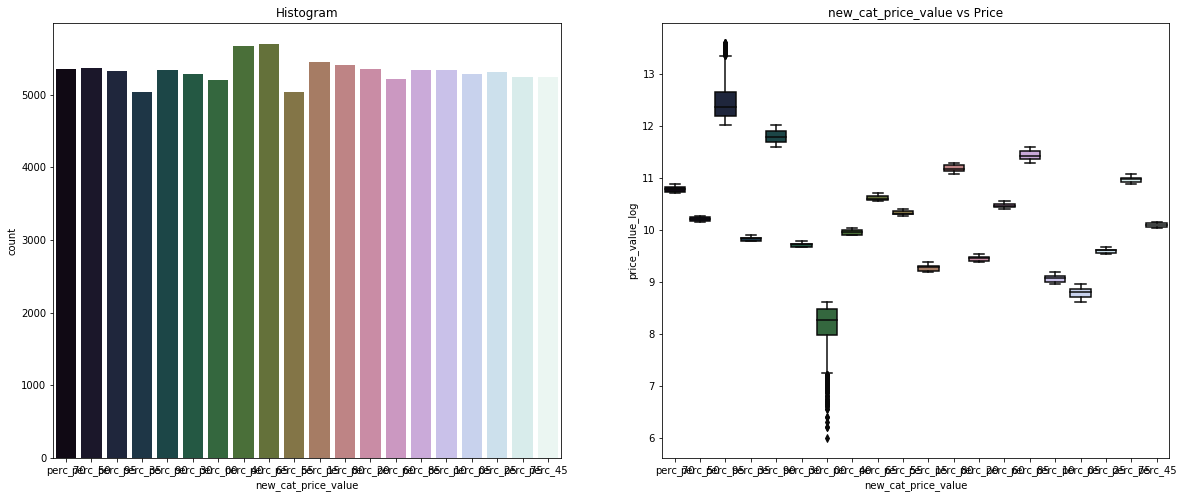

162: param_rodzaj_paliwa_2 [100.00%=160616/160616]: 
Diesel         81448
Benzyna        70632
Benzyna+LPG     7187
Hybryda          960
NA               162
Elektryczny      125
Benzyna+CNG      102
Name: param_rodzaj_paliwa_2, dtype: int64


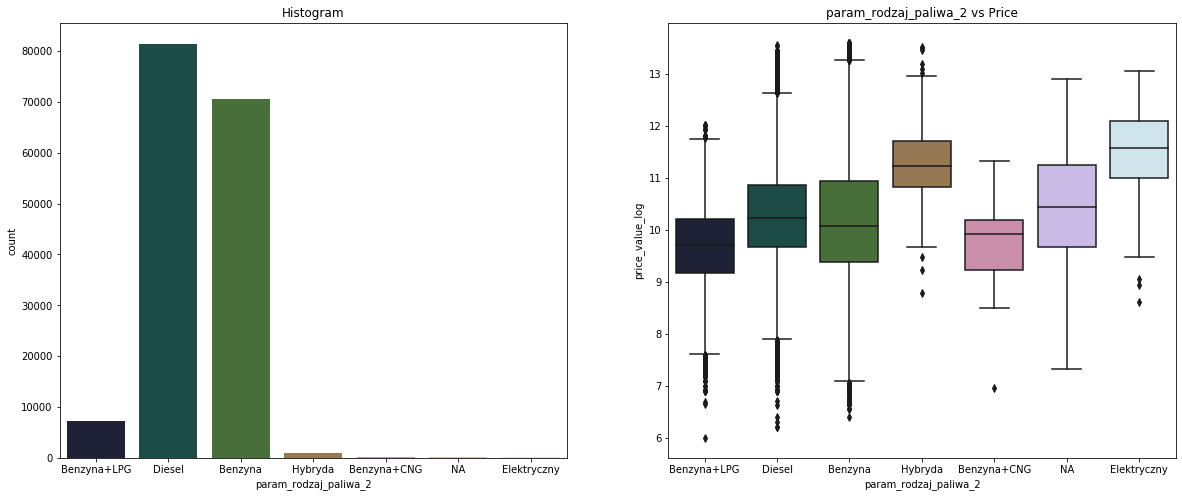

164: param_skrzynia_biegów_2 [100.00%=160616/160616]: 
Manualna                                 110681
Automatyczna hydrauliczna (klasyczna)     27955
Automatyczna dwusprzęgłowa (DCT, DSG)      9629
NA                                         8745
Automatyczna bezstopniowa (CVT)            2302
Półautomatyczna (ASG, Tiptronic)           1304
Name: param_skrzynia_biegów_2, dtype: int64


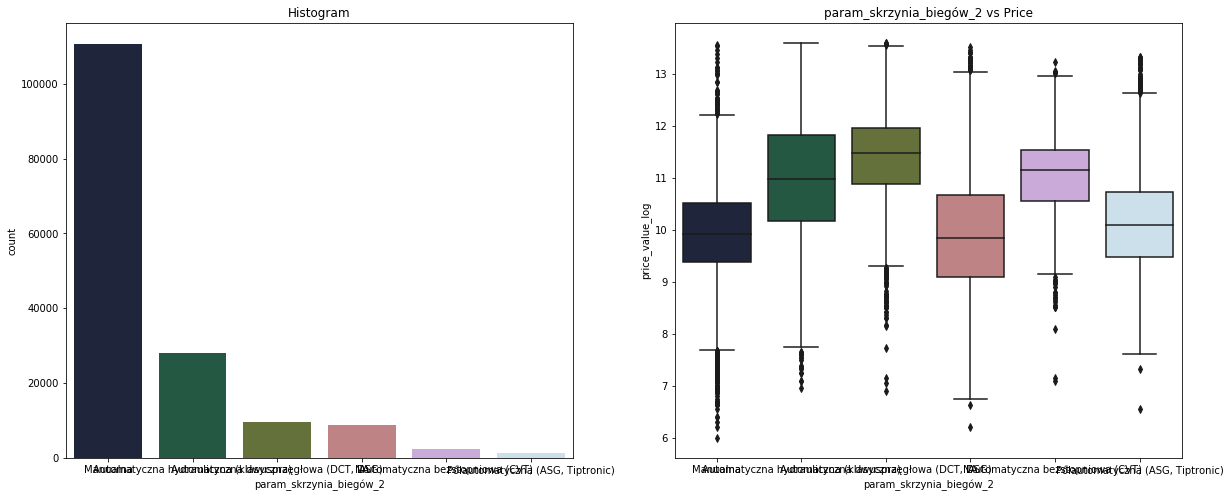

166: param_napęd_2 [100.00%=160616/160616]: 
Na przednie koła                 99630
NA                               24613
Na tylne koła                    12967
4x4 (stały)                      10641
4x4 (dołączany automatycznie)    10341
4x4 (dołączany ręcznie)           2424
Name: param_napęd_2, dtype: int64


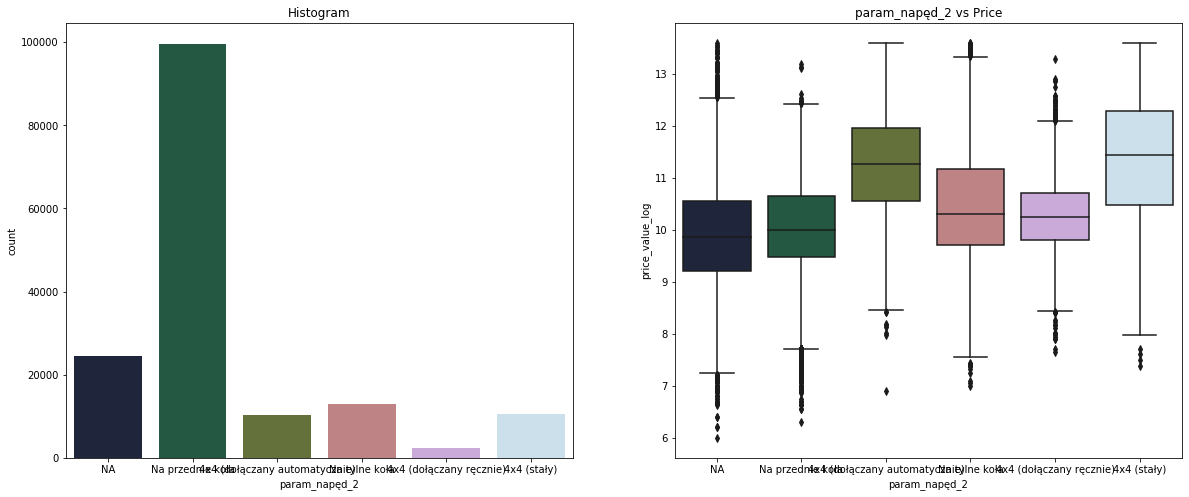

168: param_kolor_2 [100.00%=160616/160616]: 
Czarny        39267
Srebrny       29515
Szary         21927
Biały         17687
Niebieski     17423
Inny kolor    11467
Czerwony       6246
Brązowy        4284
Zielony        3872
Bordowy        2850
Złoty          2448
Beżowy         2113
Fioletowy       736
Żółty           620
NA              161
Name: param_kolor_2, dtype: int64


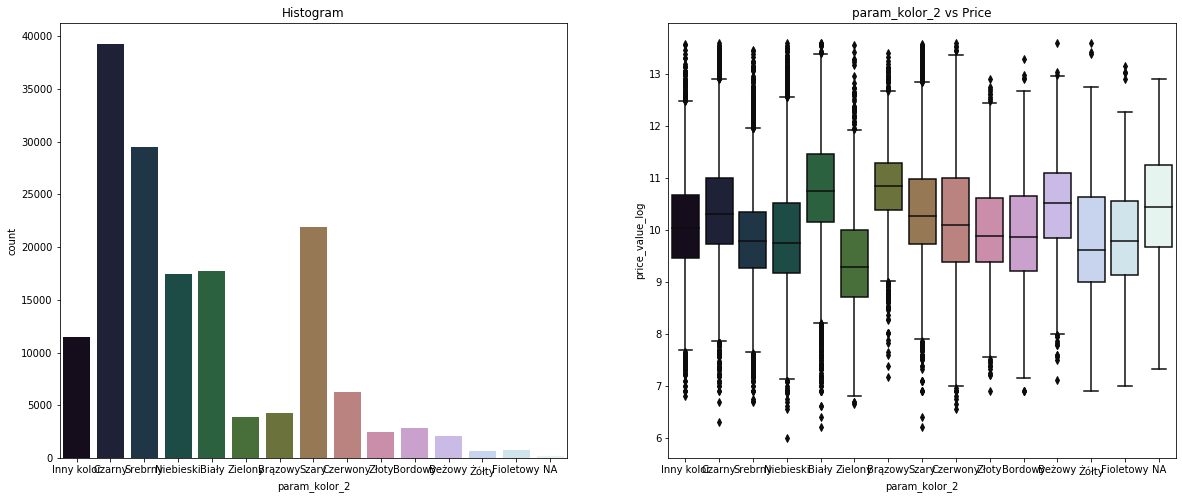

171: vin_where [100.00%=160616/160616]: 
172: vin_flex_fuel [100.00%=160616/160616]: 
173: vin_portrait [100.00%=160616/160616]: 
174: vin_security [100.00%=160616/160616]: 
175: vin_model [100.00%=160616/160616]: 
176: vin_plant [100.00%=160616/160616]: 
177: param_typ_2 [100.00%=160616/160616]: 
Kombi            33012
Sedan            27052
Kompakt          24864
SUV              24266
Auta miejskie    20538
Minivan          19789
Auta małe         5407
Coupe             4051
Kabriolet         1430
_NA_Inne           164
Hatchback           43
Name: param_typ_2, dtype: int64


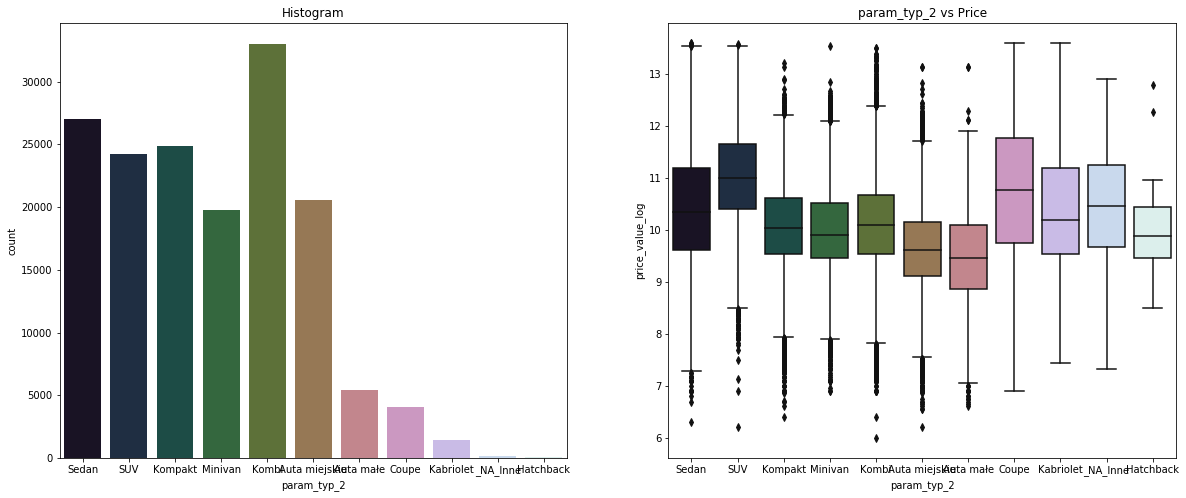

185: seller_wojewodzctwo [100.00%=160616/160616]: 
Mazowieckie            27958
Wielkopolskie          23661
Śląskie                19115
Małopolskie            15668
Dolnośląskie           11977
Łódzkie                 9687
Pomorskie               9672
Lubelskie               7086
Kujawsko-pomorskie      6908
Zachodniopomorskie      5623
Podkarpackie            4933
Świętokrzyskie          4933
Warmińsko-Mazurskie     3767
Lubuskie                3109
Podlaskie               2928
Opolskie                2740
-1                       851
Name: seller_wojewodzctwo, dtype: int64


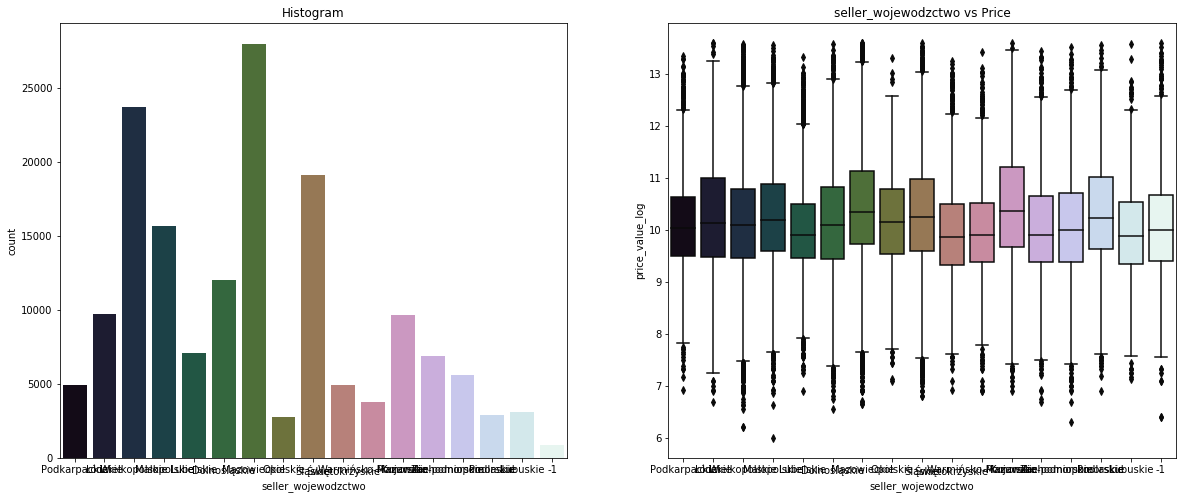

In [215]:
print_plots_by_type(total, type =[np.object])

In [ ]:
## modelowanie

In [5]:
train_30 = pd.read_hdf('output/train_30.h5', 'data') 
test_car_ids = train_30['car_id'].values

train_70 = total[~total['car_id'].isin(test_car_ids) & ~total['price_value'].isna()]
train_30 = total[total['car_id'].isin(test_car_ids)]

print(len(total.index))
print(len(total[~total['price_value'].isna()].index))

print(train_70['price_value'].isna().sum())
print(train_30['price_value'].isna().sum())

train_100 = total[~total['price_value'].isna()]
print(train_100['price_value'].isna().sum())

global_min = total[~total['price_value'].isna()].price_value.min()


160616
106494
0
0
0


In [6]:
start_vars=  ['feature_czujniki_parkowania_przednie', 'feature_poduszka_powietrzna_chroniąca_kolana', 'feature_kurtyny_powietrzne', 'feature_klimatyzacja_dwustrefowa', 'feature_światła_led', 'feature_czujnik_zmierzchu', 'feature_elektrycznie_ustawiane_lusterka', 'feature_asr__kontrola_trakcji_', 'feature_poduszka_powietrzna_kierowcy', 'feature_cd', 'feature_elektryczne_szyby_przednie', 'feature_poduszka_powietrzna_pasażera', 'feature_system_start_stop', 'feature_światła_do_jazdy_dziennej', 'feature_komputer_pokładowy', 'feature_elektryczne_szyby_tylne', 'feature_klimatyzacja_manualna', 'feature_tapicerka_welurowa', 'feature_czujnik_deszczu', 'feature_światła_przeciwmgielne', 'feature_ogrzewanie_postojowe', 'feature_radio_niefabryczne', 'feature_regulowane_zawieszenie', 'feature_ogranicznik_prędkości', 'feature_zmieniarka_cd', 'feature_szyberdach', 'feature_isofix', 'feature_asystent_pasa_ruchu', 'feature_alufelgi', 'feature_bluetooth', 'feature_nawigacja_gps', 'feature_asystent_parkowania', 'feature_wspomaganie_kierownicy', 'feature_podgrzewana_przednia_szyba', 'feature_przyciemniane_szyby', 'feature_elektrycznie_ustawiane_fotele', 'feature_klimatyzacja_czterostrefowa', 'feature_tuner_tv', 'feature_poduszki_boczne_przednie', 'feature_tempomat_aktywny', 'feature_klimatyzacja_automatyczna', 'feature_poduszki_boczne_tylne', 'feature_radio_fabryczne', 'feature_odtwarzacz_dvd', 'feature_czujniki_parkowania_tylne', 'feature_łopatki_zmiany_biegów', 'feature_centralny_zamek', 'feature_dach_panoramiczny', 'feature_kamera_cofania', 'feature_immobilizer', 'feature_czujnik_martwego_pola', 'feature_gniazdo_sd', 'feature_podgrzewane_lusterka_boczne', 'feature_podgrzewane_przednie_siedzenia', 'feature_hak', 'feature_abs', 'feature_wielofunkcyjna_kierownica', 'feature_światła_xenonowe', 'feature_gniazdo_usb', 'feature_tapicerka_skórzana', 'feature_gniazdo_aux', 'feature_esp__stabilizacja_toru_jazdy_', 'feature_alarm', 'feature_podgrzewane_tylne_siedzenia', 'feature_mp3', 'feature_tempomat', 'feature_hud__wyświetlacz_przezierny_', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_relingi_dachowe', 'feature_elektrochromatyczne_lusterka_boczne', 
              'param_faktura_vat', 'param_homologacja_ciężarowa', 'param_vat_marża', 
              'param_zarejestrowany_jako_zabytek', 'param_vat_discount', 'param_kierownica_po_prawej__anglik_', 
              'param_vat_free', 'param_tuning', 'param_matowy', 
#               'param_liczba_miejsc',  #### to bylo, ale sa braki
              'param_liczba_miejsc_2', 
              'param_liczba_drzwi', 
              'param_serwisowany_w_aso', 'param_pierwszy_właściciel', 'param_bezwypadkowy', 
              'param_zarejestrowany_w_polsce', 'param_moc', 'param_rok_produkcji', 'param_pojemność_skokowa', 
              'param_filtr_cząstek_stałych', 'param_uszkodzony', 'param_przebieg', 'param_perłowy', 
              'param_metalik', 'param_leasing', 'param_możliwość_finansowania', 'param_akryl__niemetalizowany_', 
#               'param_pierwsza_rejestracja_date', #### to bylo, ale sa braki
              'param_pierwsza_rejestracja_date_na',
              'price_currency_pln', 'new_seller_address_cat', 
              'new_seller_name_cat', 'new_seller_type_cat', 'new_param_vin_cat', 'new_param_kategoria_cat', 
              'new_param_wartość_wykupu_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_oferta_od_cat', 
              'new_param_opłata_początkowa_cat', 'new_param_stan_cat', 'new_param_marka_pojazdu_cat', 
              'new_param_model_pojazdu_cat', 'new_param_kod_silnika_cat', 'new_param_pierwsza_rejestracja_cat', 
              'new_param_kraj_pochodzenia_cat', 'new_param_skrzynia_biegów_cat', 'new_param_kolor_cat', 
              'new_param_napęd_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_typ_cat', 'new_param_emisja_co2_cat',
              'new_param_miesięczna_rata_cat', 'new_param_wersja_cat']
start_vars = np.sort(start_vars)

### moje
# obj_feats = list(total.select_dtypes(np.object).columns)
# obj_feats = [x for x in obj_feats if x.startswith('vin_')]

# for feat in obj_feats:
#     total["new_{}_cat".format(feat)] = total[feat].factorize()[0]

### Vladimir
# obj_feats = list(total.select_dtypes(np.object).columns)
# obj_feats = [x for x in obj_feats if x.startswith('param') or x.startswith('seller')]

# for feat in obj_feats:
#     total["new_{}_cat".format(feat)] = total[feat].factorize()[0]

black_list = ['car_id', 'price_details', 'price_value', 'price_value_log', 'price_value_pln', 'price_value_pln_log_transl', 'new_cat_price_value',
              *[x for x in total.columns if x.startswith('model_')],
              *total.columns[total.isnull().any()],
#               'encoded_price_currency', 
#               'price_currency_pln'
#               'created_at_unix_na_mean',
#               'created_at_unix', 
#               'pln_to_eur', 
#               'latitude', 'longitude', 
#               'latitude_na_mean', 'longitude_na_mean', 
#               'seller_address_cat', 'seller_name_cat', 'seller_type_cat', 
#               'new_cat_seller_address', 
#               'new_seller_address_cat', 'new_seller_name_cat', 'new_seller_type_cat', 
#               'new_param_vin_cat', 'param_vin_len', 
#               'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_napęd_cat', 'new_param_kolor_cat', 'new_param_typ_cat',
#               'new_param_wartość_wykupu_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_opłata_początkowa_cat', 'new_param_emisja_co2_cat', 'new_param_miesięczna_rata_cat',
#               'new_param_pierwsza_rejestracja_cat',
             ]

feats = total.select_dtypes(include=[np.number, np.bool]).columns

feats = [x for x in feats if x not in black_list]
# feats = [x for x in feats if not x.endswith('_cat')]
feats = np.sort(feats)

feats2 = np.unique([*feats, *start_vars])
feats2 = np.sort(feats2)

# total[start_vars].info(verbose=True)
# total[feats].info(verbose=True)
total[feats2].info(verbose=True)
# black_list

print(total[feats2].columns[total[feats2].isnull().any()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 147 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   created_at_unix                                float64
 1   created_at_unix_na_mean                        float64
 2   encoded_param_kolor_2                          int64  
 3   encoded_param_napęd_2                          int64  
 4   encoded_param_rodzaj_paliwa_2                  int64  
 5   encoded_param_skrzynia_biegów_2                int64  
 6   encoded_param_typ_2                            int64  
 7   feature_abs                                    bool   
 8   feature_alarm                                  bool   
 9   feature_alufelgi                               bool   
 10  feature_asr__kontrola_trakcji_                 bool   
 11  feature_asystent_parkowania                    bool   
 12  feature_asystent_pasa_ruchu                

In [11]:
start_vars_small = [x for x in total.columns if x.startswith('feature_')]
total[start_vars_small].info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 70 columns):
 #   Column                                         Non-Null Count   Dtype
---  ------                                         --------------   -----
 0   feature_czujniki_parkowania_przednie           160616 non-null  bool 
 1   feature_poduszka_powietrzna_chroniąca_kolana   160616 non-null  bool 
 2   feature_kurtyny_powietrzne                     160616 non-null  bool 
 3   feature_klimatyzacja_dwustrefowa               160616 non-null  bool 
 4   feature_światła_led                            160616 non-null  bool 
 5   feature_czujnik_zmierzchu                      160616 non-null  bool 
 6   feature_elektrycznie_ustawiane_lusterka        160616 non-null  bool 
 7   feature_asr__kontrola_trakcji_                 160616 non-null  bool 
 8   feature_poduszka_powietrzna_kierowcy           160616 non-null  bool 
 9   feature_cd                                     160616 non-n

mea: 7557.928301611125
r2: 0.9080883663483496
Learning curve for: XGBRegressor


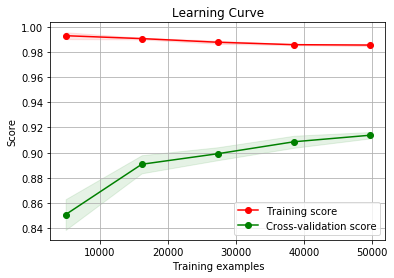

In [19]:
params = {    
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
    'max_depth': 10, 
}

mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                 start_vars, global_min, 
                 xgb.XGBRegressor, params,
                 file_sufix = 'vars_search_train_70', opis='', 
                 learning_curve = True, 
                 add_model_column_min = -1, total = total, 
                 save_min=7000, kaggle_min=-1)


In [9]:
def replace_feature(current_vars, old, new):
    current_vars = np.array(current_vars)
    current_vars = list(current_vars)
    current_vars.remove(old)
    current_vars.append(new)
    return np.sort(current_vars)

replace_feature(['a', 'b', 'c'], 'b', 'e')

array(['a', 'c', 'e'], dtype='<U1')

In [10]:
import random

def mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far):
    
    def diff(a, b):
        return np.concatenate([np.setdiff1d(a,b), np.setdiff1d(b,a)])
    
#     vars_to_draw_from = diff(current_vars, all_vars)
    vars_to_draw_from = [x for x in all_vars if x not in current_vars]
#     vars_to_draw_from = diff(vars_to_draw_from, added_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in added_so_far]
#     vars_to_draw_from = diff(vars_to_draw_from, removed_so_far)
    vars_to_draw_from = [x for x in vars_to_draw_from if x not in removed_so_far]
    
    last_trial = False
    if len(vars_to_draw_from) == 1: last_trial = True

    print(vars_to_draw_from)
    added = np.random.choice(vars_to_draw_from, 1)[0]
    removed = np.random.choice(np.setdiff1d(current_vars, added), 1)[0]
    print(removed)
    print(added)
    current_vars = replace_feature(current_vars, removed, added)
    print(current_vars)
    
    return current_vars, added, np.append(added_so_far, added), removed, np.append(removed_so_far, removed), last_trial

added_so_far = []
removed_so_far = []
current_vars = ['a', 'b', 'c', 'd', 'e']
all_vars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far)

['f', 'g', 'h', 'i']
a
f
['b' 'c' 'd' 'e' 'f']


(array(['b', 'c', 'd', 'e', 'f'], dtype='<U1'),
 'f',
 array(['f'], dtype='<U32'),
 'a',
 array(['a'], dtype='<U32'),
 False)

In [11]:
start_vars_2 = ['created_at_unix', 'encoded_param_napęd_2', 'encoded_param_typ_2', 'feature_alarm', 
                'feature_alufelgi', 'feature_asr__kontrola_trakcji_', 'feature_asystent_pasa_ruchu', 'feature_bluetooth', 'feature_cd', 'feature_centralny_zamek', 'feature_czujniki_parkowania_tylne', 'feature_elektrochromatyczne_lusterka_boczne', 'feature_elektrochromatyczne_lusterko_wsteczne', 'feature_elektryczne_szyby_tylne', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_esp__stabilizacja_toru_jazdy_', 'feature_gniazdo_sd', 'feature_gniazdo_usb', 'feature_hud__wyświetlacz_przezierny_', 'feature_isofix', 'feature_kamera_cofania', 'feature_kurtyny_powietrzne', 'feature_mp3', 'feature_nawigacja_gps', 'feature_odtwarzacz_dvd', 'feature_podgrzewana_przednia_szyba', 'feature_podgrzewane_lusterka_boczne', 'feature_podgrzewane_przednie_siedzenia', 'feature_poduszka_powietrzna_chroniąca_kolana', 'feature_poduszka_powietrzna_kierowcy', 'feature_poduszka_powietrzna_pasażera', 'feature_poduszki_boczne_przednie', 'feature_przyciemniane_szyby', 'feature_radio_niefabryczne', 'feature_regulowane_zawieszenie', 'feature_relingi_dachowe', 'feature_system_start_stop', 'feature_szyberdach', 'feature_tapicerka_welurowa', 'feature_tempomat_aktywny', 'feature_tuner_tv', 'feature_wspomaganie_kierownicy', 'feature_zmieniarka_cd', 'feature_łopatki_zmiany_biegów', 'feature_światła_do_jazdy_dziennej', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'feature_światła_xenonowe', 'longitude', 'new_param_kod_silnika_cat', 'new_param_kraj_pochodzenia_cat', 'new_param_marka_pojazdu_cat', 'new_param_miesięczna_rata_cat', 'new_param_model_pojazdu_cat', 'new_param_rodzaj_paliwa_cat', 'new_param_skrzynia_biegów_cat', 'new_param_typ_cat', 'new_param_wersja_cat', 'new_seller_name_cat', 'new_seller_type_cat', 'new_vin_model_cat', 'param_akryl__niemetalizowany_', 'param_homologacja_ciężarowa', 
                'param_leasing', 'param_moc', 'param_przebieg', 'param_rok_produkcji', 'param_uszkodzony', 'price_currency_pln']

In [12]:
import contextlib
import warnings
warnings.filterwarnings("ignore")

params = {    
    'n_jobs': 8, 
    'n_estimators': 50, 
    'learning_rate': 0.3, 
    'subsample': 0.5, 
    'colsample_bytree': 0.9,
    'max_depth': 10, 
}

mae_global_min = 7569.757078972848
big_iter = 0

current_vars=start_vars_2 #mniejszy set
all_vars = feats2 #maksymalny set

while True:

    added_so_far = []
    removed_so_far = []

    last_added = None
    last_removed = None

    last_trial = False
    big_iter += 1
    print("START iter=" + str(big_iter) + ', mae_global_min=' + str(mae_global_min))
    
    while True:
        with contextlib.redirect_stdout(None):
            current_vars, last_added, added_so_far, last_removed, removed_so_far, last_trial =  mutate_rand_feature(current_vars, all_vars, added_so_far, removed_so_far)
        print('added: ' + last_added)
        print('removed: ' + last_removed)
        print('len: ' + str(len(current_vars)))

        mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                     current_vars, global_min, 
                     xgb.XGBRegressor, params,
                     file_sufix = 'vars_search_train_70', opis='', subfolder='small',
                     learning_curve = False, 
                     add_model_column_min = -1, total = total, 
                     save_min=mae_global_min, kaggle_min=-1)

        if mae < mae_global_min:
            mae_global_min = mae
            print('Improvement: ' + last_removed + ' -> ' + last_added)
        else:
            current_vars = replace_feature(current_vars, last_added, last_removed)
            print('Rollback: ' + last_added + ' -> ' + last_removed)
        print('=============================================' + str(mae_global_min)+ '=============================================')

        if last_trial == True: 
            print("END iter=" + str(big_iter) + ', mae_global_min=' + str(mae))
            break

START iter=1, mae_global_min=7569.757078972848
added: param_serwisowany_w_aso
removed: param_rok_produkcji
len: 70
mea: 9539.666384155615
r2: 0.8810642715520242
Rollback: param_serwisowany_w_aso -> param_rok_produkcji
=============================================7569.757078972848=============================================
added: feature_czujniki_parkowania_przednie
removed: feature_kamera_cofania
len: 70
mea: 7501.113446040681
r2: 0.9132713372872704
Improvement: feature_kamera_cofania -> feature_czujniki_parkowania_przednie
=============================================7501.113446040681=============================================
added: new_param_oferta_od_cat
removed: feature_elektrochromatyczne_lusterka_boczne
len: 70
mea: 7562.512781706752
r2: 0.9118192072477866
Rollback: new_param_oferta_od_cat -> feature_elektrochromatyczne_lusterka_boczne
=============================================7501.113446040681=============================================
added: param_miesięczna_rata_2
re

mea: 7658.430438872824
r2: 0.9052813047658742
Rollback: feature_klimatyzacja_manualna -> feature_wspomaganie_kierownicy
=============================================7452.591676305646=============================================
added: longitude_na_mean
removed: param_uszkodzony
len: 70
mea: 8005.445399590858
r2: 0.9027702804870394
Rollback: longitude_na_mean -> param_uszkodzony
=============================================7452.591676305646=============================================
added: feature_gniazdo_aux
removed: param_uszkodzony
len: 70
mea: 8028.85105958529
r2: 0.9053008633444126
Rollback: feature_gniazdo_aux -> param_uszkodzony
=============================================7452.591676305646=============================================
added: feature_asystent_parkowania
removed: new_param_miesięczna_rata_cat
len: 70
mea: 7606.212055386291
r2: 0.9072697899720862
Rollback: feature_asystent_parkowania -> new_param_miesięczna_rata_cat
=============================================745

mea: 7601.652352800221
r2: 0.9092353717061624
Rollback: feature_immobilizer -> new_param_miesięczna_rata_cat
=============================================7440.130573229718=============================================
added: param_pierwsza_rejestracja_date_na
removed: feature_przyciemniane_szyby
len: 70
mea: 7569.011335000199
r2: 0.9138248963622067
Rollback: param_pierwsza_rejestracja_date_na -> feature_przyciemniane_szyby
=============================================7440.130573229718=============================================
added: encoded_param_kolor_2
removed: feature_tapicerka_welurowa
len: 70
mea: 7607.319012954484
r2: 0.9039832489119449
Rollback: encoded_param_kolor_2 -> feature_tapicerka_welurowa
=============================================7440.130573229718=============================================
added: param_liczba_miejsc_2
removed: feature_zmieniarka_cd
len: 70
mea: 7508.180238366537
r2: 0.9156474800828585
Rollback: param_liczba_miejsc_2 -> feature_zmieniarka_cd
======

mea: 7738.641848134674
r2: 0.9012861139485795
Rollback: param_zarejestrowany_w_polsce -> feature_alufelgi
=============================================7440.130573229718=============================================
added: new_param_oferta_od_cat
removed: param_akryl__niemetalizowany_
len: 70
mea: 7499.759982022129
r2: 0.9110034918976055
Rollback: new_param_oferta_od_cat -> param_akryl__niemetalizowany_
=============================================7440.130573229718=============================================
added: new_vin_where_cat
removed: feature_przyciemniane_szyby
len: 70
mea: 7520.74200831588
r2: 0.9134309726853792
Rollback: new_vin_where_cat -> feature_przyciemniane_szyby
=============================================7440.130573229718=============================================
added: feature_elektryczne_szyby_przednie
removed: feature_czujniki_parkowania_tylne
len: 70
mea: 7516.512433745726
r2: 0.9116007185256679
Rollback: feature_elektryczne_szyby_przednie -> feature_czujniki_p

mea: 7551.4376644773765
r2: 0.9076519151629834
Rollback: encoded_param_rodzaj_paliwa_2 -> feature_relingi_dachowe
=============================================7440.130573229718=============================================
added: param_emisja_co2_2
removed: feature_tuner_tv
len: 70
mea: 7521.071628587077
r2: 0.9119596049632378
Rollback: param_emisja_co2_2 -> feature_tuner_tv
=============================================7440.130573229718=============================================
added: param_vin_len
removed: new_param_kod_silnika_cat
len: 70
mea: 7638.045239435555
r2: 0.9102930447382698
Rollback: param_vin_len -> new_param_kod_silnika_cat
=============================================7440.130573229718=============================================
added: new_vin_flex_fuel_cat
removed: param_rok_produkcji
len: 70
mea: 9611.25953295193
r2: 0.8818865304710902
Rollback: new_vin_flex_fuel_cat -> param_rok_produkcji
=============================================7440.130573229718================

mea: 7692.082038361401
r2: 0.9069921756556597
Rollback: new_param_opłata_początkowa_cat -> feature_cd
=============================================7440.130573229718=============================================
added: param_pojemność_skokowa
removed: param_akryl__niemetalizowany_
len: 70
mea: 7558.358864899614
r2: 0.9126354464756915
Rollback: param_pojemność_skokowa -> param_akryl__niemetalizowany_
=============================================7440.130573229718=============================================
added: new_param_napęd_cat
removed: created_at_unix_na_mean
len: 70
mea: 7603.655828519626
r2: 0.9059472066034171
Rollback: new_param_napęd_cat -> created_at_unix_na_mean
=============================================7440.130573229718=============================================
added: pln_to_eur
removed: new_param_rodzaj_paliwa_cat
len: 70
mea: 7747.205202042892
r2: 0.9046231842353105
Rollback: pln_to_eur -> new_param_rodzaj_paliwa_cat
=============================================7440.1

mea: 7516.937266251838
r2: 0.912476381356015
Rollback: feature_tempomat -> feature_poduszka_powietrzna_pasażera
=============================================7440.130573229718=============================================
added: param_vat_discount
removed: feature_podgrzewana_przednia_szyba
len: 70
mea: 7611.322325699839
r2: 0.9109313472091347
Rollback: param_vat_discount -> feature_podgrzewana_przednia_szyba
=============================================7440.130573229718=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: new_param_wersja_cat
len: 70
mea: 7731.518738691695
r2: 0.9060860376226907
Rollback: feature_podgrzewane_tylne_siedzenia -> new_param_wersja_cat
=============================================7440.130573229718=============================================
added: latitude
removed: feature_podgrzewane_przednie_siedzenia
len: 70
mea: 7506.841702581577
r2: 0.9137388783122773
Rollback: latitude -> feature_podgrzewane_przednie_siedzen

mea: 7651.933459359867
r2: 0.9041466313348983
Rollback: encoded_param_kolor_2 -> new_param_miesięczna_rata_cat
=============================================7440.130573229718=============================================
added: feature_poduszki_boczne_tylne
removed: new_param_rodzaj_paliwa_cat
len: 70
mea: 7781.036376608414
r2: 0.9051103723018029
Rollback: feature_poduszki_boczne_tylne -> new_param_rodzaj_paliwa_cat
=============================================7440.130573229718=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_radio_niefabryczne
len: 70
mea: 7540.631430556547
r2: 0.9126563635772487
Rollback: feature_klimatyzacja_dwustrefowa -> feature_radio_niefabryczne
=============================================7440.130573229718=============================================
added: feature_ogrzewanie_postojowe
removed: feature_cd
len: 70
mea: 7751.055537087978
r2: 0.9018847380459313
Rollback: feature_ogrzewanie_postojowe -> feature_cd


mea: 7538.874374594079
r2: 0.905721415168399
Rollback: param_pierwsza_rejestracja_date_na -> feature_cd
=============================================7404.867527681524=============================================
added: latitude_na_mean
removed: feature_poduszki_boczne_przednie
len: 70
mea: 7550.1992346760335
r2: 0.9137287279546746
Rollback: latitude_na_mean -> feature_poduszki_boczne_przednie
=============================================7404.867527681524=============================================
added: feature_czujnik_zmierzchu
removed: feature_esp__stabilizacja_toru_jazdy_
len: 70
mea: 7471.209677931146
r2: 0.9138340522593826
Rollback: feature_czujnik_zmierzchu -> feature_esp__stabilizacja_toru_jazdy_
=============================================7404.867527681524=============================================
END iter=3, mae_global_min=7471.209677931146
START iter=4, mae_global_min=7404.867527681524
added: new_param_pierwsza_rejestracja_cat
removed: feature_tapicerka_welurowa
len: 70

mea: 7572.460976021629
r2: 0.9132189259148072
Rollback: feature_ogranicznik_prędkości -> param_homologacja_ciężarowa
=============================================7404.867527681524=============================================
added: feature_immobilizer
removed: feature_światła_przeciwmgielne
len: 70
mea: 7582.642856272078
r2: 0.9085116346495308
Rollback: feature_immobilizer -> feature_światła_przeciwmgielne
=============================================7404.867527681524=============================================
added: feature_czujnik_martwego_pola
removed: longitude
len: 70
mea: 7445.853825746102
r2: 0.9124070729748939
Rollback: feature_czujnik_martwego_pola -> longitude
=============================================7404.867527681524=============================================
added: param_vat_discount
removed: param_rok_produkcji
len: 70
mea: 9481.041306170073
r2: 0.8822591259451078
Rollback: param_vat_discount -> param_rok_produkcji
=============================================7404.

mea: 7523.6597653820745
r2: 0.9127064747232899
Rollback: param_pojemność_skokowa -> feature_poduszka_powietrzna_kierowcy
=============================================7404.867527681524=============================================
added: param_zarejestrowany_w_polsce
removed: new_param_kod_silnika_cat
len: 70
mea: 7558.115253688923
r2: 0.9127763297456601
Rollback: param_zarejestrowany_w_polsce -> new_param_kod_silnika_cat
=============================================7404.867527681524=============================================
added: feature_elektryczne_szyby_przednie
removed: feature_czujniki_parkowania_tylne
len: 70
mea: 7486.12836380482
r2: 0.911621876173498
Rollback: feature_elektryczne_szyby_przednie -> feature_czujniki_parkowania_tylne
=============================================7404.867527681524=============================================
added: feature_komputer_pokładowy
removed: param_uszkodzony
len: 70
mea: 7969.2830326532685
r2: 0.9040174885830757
Rollback: feature_komputer

mea: 7638.354718629096
r2: 0.9045353825183601
Rollback: created_at_unix_na_mean -> feature_elektrochromatyczne_lusterka_boczne
=============================================7404.867527681524=============================================
added: feature_czujnik_deszczu
removed: feature_cd
len: 70
mea: 7540.700953355807
r2: 0.9135810179002791
Rollback: feature_czujnik_deszczu -> feature_cd
=============================================7404.867527681524=============================================
added: new_seller_address_cat
removed: new_param_marka_pojazdu_cat
len: 70
mea: 7873.347509293758
r2: 0.8989259547512356
Rollback: new_seller_address_cat -> new_param_marka_pojazdu_cat
=============================================7404.867527681524=============================================
added: param_liczba_pozostałych_rat_2
removed: feature_alufelgi
len: 70
mea: 7464.01990334961
r2: 0.9147862084818671
Rollback: param_liczba_pozostałych_rat_2 -> feature_alufelgi
=================================

mea: 7411.039212395039
r2: 0.9146642164738702
Rollback: feature_klimatyzacja_czterostrefowa -> new_param_vin_cat
=============================================7392.020641386666=============================================
added: new_cat_seller_address
removed: new_param_wersja_cat
len: 70
mea: 7544.791577113973
r2: 0.9137130635812662
Rollback: new_cat_seller_address -> new_param_wersja_cat
=============================================7392.020641386666=============================================
added: feature_klimatyzacja_dwustrefowa
removed: param_homologacja_ciężarowa
len: 70
mea: 7413.24114449914
r2: 0.9132258506375398
Rollback: feature_klimatyzacja_dwustrefowa -> param_homologacja_ciężarowa
=============================================7392.020641386666=============================================
added: latitude_na_mean
removed: feature_regulowane_zawieszenie
len: 70
mea: 7467.859258882626
r2: 0.9119241603871623
Rollback: latitude_na_mean -> feature_regulowane_zawieszenie
=========

mea: 7416.055301358968
r2: 0.9136681192187319
Rollback: param_kierownica_po_prawej__anglik_ -> feature_gniazdo_usb
=============================================7348.903186313539=============================================
added: feature_klimatyzacja_manualna
removed: feature_tempomat_aktywny
len: 70
mea: 7412.736206568813
r2: 0.9137504754663057
Rollback: feature_klimatyzacja_manualna -> feature_tempomat_aktywny
=============================================7348.903186313539=============================================
added: feature_czujnik_martwego_pola
removed: feature_ogrzewanie_postojowe
len: 70
mea: 7473.9744990443605
r2: 0.9088641828712042
Rollback: feature_czujnik_martwego_pola -> feature_ogrzewanie_postojowe
=============================================7348.903186313539=============================================
added: param_możliwość_finansowania
removed: encoded_param_napęd_2
len: 70
mea: 7501.123052991966
r2: 0.9136170329039411
Rollback: param_możliwość_finansowania -> enc

mea: 7718.561356303989
r2: 0.9036336267183932
Rollback: feature_ogranicznik_prędkości -> new_param_typ_cat
=============================================7348.903186313539=============================================
added: new_vin_portrait_cat
removed: param_uszkodzony
len: 70
mea: 7946.690316469416
r2: 0.9068891983783136
Rollback: new_vin_portrait_cat -> param_uszkodzony
=============================================7348.903186313539=============================================
added: param_możliwość_finansowania
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 70
mea: 7494.362272444111
r2: 0.9132794777294451
Rollback: param_możliwość_finansowania -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7348.903186313539=============================================
added: new_vin_flex_fuel_cat
removed: feature_kurtyny_powietrzne
len: 70
mea: 7490.316487907394
r2: 0.9115217970874736
Rollback: new_vin_flex_fuel_cat -> feature_kurtyny_powietr

mea: 8617.311757611604
r2: 0.8825657115162476
Rollback: param_serwisowany_w_aso -> param_moc
=============================================7348.903186313539=============================================
added: param_emisja_co2_2
removed: feature_czujniki_parkowania_przednie
len: 70
mea: 7548.75849395732
r2: 0.9089781813010651
Rollback: param_emisja_co2_2 -> feature_czujniki_parkowania_przednie
=============================================7348.903186313539=============================================
added: new_param_stan_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 70
mea: 7438.699728786045
r2: 0.9133535266361926
Rollback: new_param_stan_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7348.903186313539=============================================
added: param_vat_marża
removed: new_param_miesięczna_rata_cat
len: 70
mea: 7708.274146012692
r2: 0.9053167298111022
Rollback: param_vat_marża -> new_param_miesięczna_rata_cat
=

mea: 7504.234156200819
r2: 0.9089806915417444
Rollback: new_vin_where_cat -> feature_elektrycznie_ustawiane_lusterka
=============================================7348.903186313539=============================================
added: param_kierownica_po_prawej__anglik_
removed: feature_mp3
len: 70
mea: 7487.106806141859
r2: 0.9097550600047878
Rollback: param_kierownica_po_prawej__anglik_ -> feature_mp3
=============================================7348.903186313539=============================================
added: param_vin_len
removed: feature_światła_led
len: 70
mea: 7591.255296151542
r2: 0.9115490728526191
Rollback: param_vin_len -> feature_światła_led
=============================================7348.903186313539=============================================
added: param_miesięczna_rata_2
removed: feature_poduszka_powietrzna_pasażera
len: 70
mea: 7536.453046862774
r2: 0.9041958965140862
Rollback: param_miesięczna_rata_2 -> feature_poduszka_powietrzna_pasażera
========================

mea: 7566.436015761784
r2: 0.9088767772049013
Rollback: new_param_opłata_początkowa_cat -> feature_podgrzewane_przednie_siedzenia
=============================================7348.903186313539=============================================
added: feature_klimatyzacja_czterostrefowa
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7475.4358857181005
r2: 0.909969373631655
Rollback: feature_klimatyzacja_czterostrefowa -> feature_hud__wyświetlacz_przezierny_
=============================================7348.903186313539=============================================
added: feature_elektryczne_szyby_tylne
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7607.518561670446
r2: 0.8890464636971749
Rollback: feature_elektryczne_szyby_tylne -> feature_hud__wyświetlacz_przezierny_
=============================================7348.903186313539=============================================
added: encoded_param_rodzaj_paliwa_2
removed: feature_poduszka_powietrzna_pasażera
len: 70
mea: 

mea: 7513.192418511943
r2: 0.908183149053133
Rollback: param_matowy -> new_vin_model_cat
=============================================7348.903186313539=============================================
added: param_vat_marża
removed: param_rok_produkcji
len: 70
mea: 9541.101316162423
r2: 0.8774106037624172
Rollback: param_vat_marża -> param_rok_produkcji
=============================================7348.903186313539=============================================
added: feature_immobilizer
removed: feature_radio_niefabryczne
len: 70
mea: 7524.02173968004
r2: 0.9113219405444248
Rollback: feature_immobilizer -> feature_radio_niefabryczne
=============================================7348.903186313539=============================================
added: param_perłowy
removed: new_param_miesięczna_rata_cat
len: 70
mea: 7485.594431367569
r2: 0.9100074371146172
Rollback: param_perłowy -> new_param_miesięczna_rata_cat
=============================================7348.903186313539=======================

mea: 7388.561109383436
r2: 0.9164855164906723
Rollback: feature_klimatyzacja_czterostrefowa -> feature_gniazdo_usb
=============================================7348.903186313539=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7490.295562963951
r2: 0.9146360092584489
Rollback: feature_podgrzewane_tylne_siedzenia -> feature_elektrycznie_ustawiane_fotele
=============================================7348.903186313539=============================================
added: param_liczba_pozostałych_rat_2
removed: param_przebieg
len: 70
mea: 7837.921063768593
r2: 0.9027640212113076
Rollback: param_liczba_pozostałych_rat_2 -> param_przebieg
=============================================7348.903186313539=============================================
added: feature_klimatyzacja_manualna
removed: feature_asr__kontrola_trakcji_
len: 70
mea: 7465.407070605403
r2: 0.9109293271645553
Rollback: feature_klimat

mea: 7426.481864314177
r2: 0.9131425416113671
Rollback: param_liczba_drzwi -> new_param_kod_silnika_cat
=============================================7348.903186313539=============================================
added: param_matowy
removed: price_currency_pln
len: 70
mea: 7634.998498322109
r2: 0.9048791925570441
Rollback: param_matowy -> price_currency_pln
=============================================7348.903186313539=============================================
added: encoded_param_kolor_2
removed: feature_alarm
len: 70
mea: 7567.664988864241
r2: 0.9033770018677838
Rollback: encoded_param_kolor_2 -> feature_alarm
=============================================7348.903186313539=============================================
added: encoded_param_rodzaj_paliwa_2
removed: feature_podgrzewane_lusterka_boczne
len: 70
mea: 7400.5731735599065
r2: 0.9149881943467262
Rollback: encoded_param_rodzaj_paliwa_2 -> feature_podgrzewane_lusterka_boczne
=============================================7348.9031

mea: 7922.135779122968
r2: 0.9076596584491528
Rollback: param_opłata_początkowa_2 -> param_uszkodzony
=============================================7348.903186313539=============================================
added: param_kierownica_po_prawej__anglik_
removed: param_akryl__niemetalizowany_
len: 70
mea: 7531.79638137943
r2: 0.9073311505488262
Rollback: param_kierownica_po_prawej__anglik_ -> param_akryl__niemetalizowany_
=============================================7348.903186313539=============================================
added: param_zarejestrowany_w_polsce
removed: feature_poduszka_powietrzna_pasażera
len: 70
mea: 7525.141798509075
r2: 0.9146155935620315
Rollback: param_zarejestrowany_w_polsce -> feature_poduszka_powietrzna_pasażera
=============================================7348.903186313539=============================================
added: feature_poduszki_boczne_tylne
removed: feature_poduszka_powietrzna_kierowcy
len: 70
mea: 7419.667717849792
r2: 0.9131632604218847
Rollba

mea: 7496.225819532906
r2: 0.9106286530683052
Rollback: encoded_param_kolor_2 -> feature_hud__wyświetlacz_przezierny_
=============================================7348.903186313539=============================================
added: feature_immobilizer
removed: param_rok_produkcji
len: 70
mea: 9517.859284902335
r2: 0.8812692101992285
Rollback: feature_immobilizer -> param_rok_produkcji
=============================================7348.903186313539=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: feature_centralny_zamek
len: 70
mea: 7494.862450365001
r2: 0.9138163853587163
Rollback: feature_podgrzewane_tylne_siedzenia -> feature_centralny_zamek
=============================================7348.903186313539=============================================
added: param_perłowy
removed: new_param_kraj_pochodzenia_cat
len: 70
mea: 7647.489419537993
r2: 0.90793952690182
Rollback: param_perłowy -> new_param_kraj_pochodzenia_cat
=====================

mea: 7606.914130527578
r2: 0.9076495177291337
Rollback: created_at_unix -> new_param_vin_cat
=============================================7348.903186313539=============================================
added: feature_czujnik_zmierzchu
removed: param_homologacja_ciężarowa
len: 70
mea: 7573.489964528276
r2: 0.9101758492528278
Rollback: feature_czujnik_zmierzchu -> param_homologacja_ciężarowa
=============================================7348.903186313539=============================================
added: new_vin_flex_fuel_cat
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7401.518235331022
r2: 0.9131969676440608
Rollback: new_vin_flex_fuel_cat -> feature_elektrycznie_ustawiane_fotele
=============================================7348.903186313539=============================================
added: pln_to_eur
removed: feature_przyciemniane_szyby
len: 70
mea: 7604.465760164989
r2: 0.9089323130824292
Rollback: pln_to_eur -> feature_przyciemniane_szyby
============================

mea: 7566.634448158398
r2: 0.9089501602478283
Rollback: new_seller_wojewodzctwo_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7348.903186313539=============================================
added: feature_komputer_pokładowy
removed: new_param_kraj_pochodzenia_cat
len: 70
mea: 7540.627375596944
r2: 0.9132678208809772
Rollback: feature_komputer_pokładowy -> new_param_kraj_pochodzenia_cat
=============================================7348.903186313539=============================================
added: new_param_pierwsza_rejestracja_cat
removed: feature_tempomat_aktywny
len: 70
mea: 7489.662509944515
r2: 0.9149349010910373
Rollback: new_param_pierwsza_rejestracja_cat -> feature_tempomat_aktywny
=============================================7348.903186313539=============================================
added: new_param_opłata_początkowa_cat
removed: new_seller_name_cat
len: 70
mea: 7534.010193750486
r2: 0.913276274039347
Rollback: new_param_

mea: 7608.49339705812
r2: 0.9088817884684434
Rollback: feature_immobilizer -> feature_radio_niefabryczne
=============================================7312.5100762249995=============================================
added: created_at_unix_na_mean
removed: param_pierwszy_właściciel
len: 70
mea: 7515.873611313085
r2: 0.9040742994281168
Rollback: created_at_unix_na_mean -> param_pierwszy_właściciel
=============================================7312.5100762249995=============================================
added: new_seller_wojewodzctwo_cat
removed: feature_podgrzewane_przednie_siedzenia
len: 70
mea: 7552.0698158295245
r2: 0.9105098881691323
Rollback: new_seller_wojewodzctwo_cat -> feature_podgrzewane_przednie_siedzenia
=============================================7312.5100762249995=============================================
added: feature_hak
removed: new_param_marka_pojazdu_cat
len: 70
mea: 7753.663553072989
r2: 0.9080391013575309
Rollback: feature_hak -> new_param_marka_pojazdu_cat
====

mea: 7564.978061189692
r2: 0.9094110668054141
Rollback: new_param_pierwsza_rejestracja_cat -> param_leasing
=============================================7312.5100762249995=============================================
added: created_at_unix
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7516.44567514836
r2: 0.91086998187344
Rollback: created_at_unix -> feature_elektrycznie_ustawiane_lusterka
=============================================7312.5100762249995=============================================
added: feature_gniazdo_aux
removed: feature_asystent_pasa_ruchu
len: 70
mea: 7468.792280637749
r2: 0.9151439163632111
Rollback: feature_gniazdo_aux -> feature_asystent_pasa_ruchu
=============================================7312.5100762249995=============================================
added: feature_abs
removed: feature_kurtyny_powietrzne
len: 70
mea: 7507.654629629716
r2: 0.9142209586992498
Rollback: feature_abs -> feature_kurtyny_powietrzne
=================================

mea: 7494.6923451899775
r2: 0.9098145813510281
Rollback: feature_klimatyzacja_dwustrefowa -> feature_łopatki_zmiany_biegów
=============================================7312.5100762249995=============================================
added: encoded_param_rodzaj_paliwa_2
removed: param_homologacja_ciężarowa
len: 70
mea: 7594.533624581609
r2: 0.9032511758421892
Rollback: encoded_param_rodzaj_paliwa_2 -> param_homologacja_ciężarowa
=============================================7312.5100762249995=============================================
added: feature_elektryczne_szyby_przednie
removed: feature_światła_led
len: 70
mea: 7527.348603100687
r2: 0.9111158243703736
Rollback: feature_elektryczne_szyby_przednie -> feature_światła_led
=============================================7312.5100762249995=============================================
added: new_param_oferta_od_cat
removed: feature_cd
len: 70
mea: 7469.842831945244
r2: 0.9051773082024328
Rollback: new_param_oferta_od_cat -> feature_cd
=====

mea: 7544.8726618460005
r2: 0.9104101396436924
Rollback: new_seller_address_cat -> feature_łopatki_zmiany_biegów
=============================================7312.5100762249995=============================================
added: created_at_unix
removed: feature_cd
len: 70
mea: 7766.191850918041
r2: 0.9033271365056806
Rollback: created_at_unix -> feature_cd
=============================================7312.5100762249995=============================================
added: new_seller_wojewodzctwo_cat
removed: param_rok_produkcji
len: 70
mea: 9569.700708140776
r2: 0.8759526930933557
Rollback: new_seller_wojewodzctwo_cat -> param_rok_produkcji
=============================================7312.5100762249995=============================================
added: new_vin_security_cat
removed: feature_poduszki_boczne_przednie
len: 70
mea: 7499.018558407648
r2: 0.9097012195905566
Rollback: new_vin_security_cat -> feature_poduszki_boczne_przednie
=============================================7312.510

mea: 7647.581115554083
r2: 0.8959910014743403
Rollback: encoded_param_kolor_2 -> new_vin_model_cat
=============================================7312.5100762249995=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: feature_centralny_zamek
len: 70
mea: 7483.756779977572
r2: 0.9129795196192638
Rollback: feature_podgrzewane_tylne_siedzenia -> feature_centralny_zamek
=============================================7312.5100762249995=============================================
added: feature_dach_panoramiczny
removed: feature_gniazdo_usb
len: 70
mea: 7528.317759582945
r2: 0.906115096239349
Rollback: feature_dach_panoramiczny -> feature_gniazdo_usb
=============================================7312.5100762249995=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: feature_tempomat_aktywny
len: 70
mea: 7412.489022817081
r2: 0.9134165484358423
Rollback: new_param_liczba_pozostałych_rat_cat -> feature_tempoma

mea: 7467.192206076588
r2: 0.9150786760742236
Rollback: feature_klimatyzacja_automatyczna -> feature_tapicerka_welurowa
=============================================7312.5100762249995=============================================
added: created_at_unix_na_mean
removed: feature_gniazdo_sd
len: 70
mea: 7592.35955117097
r2: 0.9040064600292455
Rollback: created_at_unix_na_mean -> feature_gniazdo_sd
=============================================7312.5100762249995=============================================
added: feature_klimatyzacja_dwustrefowa
removed: new_param_rodzaj_paliwa_cat
len: 70
mea: 7584.037091773553
r2: 0.9128305434398352
Rollback: feature_klimatyzacja_dwustrefowa -> new_param_rodzaj_paliwa_cat
=============================================7312.5100762249995=============================================
added: feature_tempomat
removed: longitude
len: 70
mea: 7490.724707927606
r2: 0.9126722060256625
Rollback: feature_tempomat -> longitude
===========================================

mea: 7468.8661845632205
r2: 0.9116357242566534
Rollback: new_seller_wojewodzctwo_cat -> feature_poduszka_powietrzna_kierowcy
=============================================7312.5100762249995=============================================
added: new_vin_portrait_cat
removed: feature_tapicerka_welurowa
len: 70
mea: 7562.315223532944
r2: 0.9079816573071396
Rollback: new_vin_portrait_cat -> feature_tapicerka_welurowa
=============================================7312.5100762249995=============================================
added: feature_ogranicznik_prędkości
removed: feature_radio_niefabryczne
len: 70
mea: 7453.36889113749
r2: 0.9169103521114482
Rollback: feature_ogranicznik_prędkości -> feature_radio_niefabryczne
=============================================7312.5100762249995=============================================
added: param_vat_free
removed: feature_przyciemniane_szyby
len: 70
mea: 7518.512308372189
r2: 0.9125988387486907
Rollback: param_vat_free -> feature_przyciemniane_szyby
====

mea: 7726.415389082473
r2: 0.9006406386032686
Rollback: created_at_unix -> feature_podgrzewana_przednia_szyba
=============================================7312.5100762249995=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: param_pierwszy_właściciel
len: 70
mea: 7439.362530572101
r2: 0.9131585549471227
Rollback: new_param_liczba_pozostałych_rat_cat -> param_pierwszy_właściciel
=============================================7312.5100762249995=============================================
added: param_liczba_drzwi
removed: feature_tuner_tv
len: 70
mea: 7440.074346877865
r2: 0.9111605716922093
Rollback: param_liczba_drzwi -> feature_tuner_tv
=============================================7312.5100762249995=============================================
added: param_matowy
removed: feature_szyberdach
len: 70
mea: 7573.452086010736
r2: 0.9074045246861518
Rollback: param_matowy -> feature_szyberdach
=============================================7312.51

mea: 7368.469027478516
r2: 0.916890143737453
Rollback: new_param_emisja_co2_cat -> feature_tapicerka_skórzana
=============================================7312.5100762249995=============================================
added: param_serwisowany_w_aso
removed: feature_bluetooth
len: 70
mea: 7632.924484425113
r2: 0.911631560621848
Rollback: param_serwisowany_w_aso -> feature_bluetooth
=============================================7312.5100762249995=============================================
added: param_vat_marża
removed: param_akryl__niemetalizowany_
len: 70
mea: 7561.595560497556
r2: 0.912579287617833
Rollback: param_vat_marża -> param_akryl__niemetalizowany_
=============================================7312.5100762249995=============================================
added: new_param_kolor_cat
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7417.373282298653
r2: 0.9111213759020848
Rollback: new_param_kolor_cat -> feature_hud__wyświetlacz_przezierny_
==========================

mea: 7560.072817284427
r2: 0.9134161925011924
Rollback: param_vat_discount -> feature_szyberdach
=============================================7312.5100762249995=============================================
added: feature_czujnik_martwego_pola
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7561.753474821902
r2: 0.9071937198395917
Rollback: feature_czujnik_martwego_pola -> feature_elektrycznie_ustawiane_lusterka
=============================================7312.5100762249995=============================================
added: longitude_na_mean
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7372.5272113175615
r2: 0.9155872398905212
Rollback: longitude_na_mean -> feature_wspomaganie_kierownicy
=============================================7312.5100762249995=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_cd
len: 70
mea: 7427.448795594364
r2: 0.9150622803055605
Rollback: feature_klimatyzacja_dwustrefowa -> feature_cd


mea: 7515.185300321625
r2: 0.9080709737396553
Rollback: param_liczba_pozostałych_rat_2 -> feature_podgrzewana_przednia_szyba
=============================================7312.5100762249995=============================================
added: new_param_oferta_od_cat
removed: feature_tapicerka_welurowa
len: 70
mea: 7402.544945956578
r2: 0.9136849090726444
Rollback: new_param_oferta_od_cat -> feature_tapicerka_welurowa
=============================================7312.5100762249995=============================================
added: feature_ogranicznik_prędkości
removed: feature_isofix
len: 70
mea: 7502.518230210175
r2: 0.9140823061245564
Rollback: feature_ogranicznik_prędkości -> feature_isofix
=============================================7312.5100762249995=============================================
added: param_pojemność_skokowa
removed: feature_radio_fabryczne
len: 70
mea: 7479.938043047183
r2: 0.9115384744106478
Rollback: param_pojemność_skokowa -> feature_radio_fabryczne
===========

mea: 7423.107025339243
r2: 0.912472157503041
Rollback: param_możliwość_finansowania -> new_vin_model_cat
=============================================7312.5100762249995=============================================
added: feature_czujnik_martwego_pola
removed: feature_alarm
len: 70
mea: 7542.535695221703
r2: 0.9082267893969911
Rollback: feature_czujnik_martwego_pola -> feature_alarm
=============================================7312.5100762249995=============================================
added: param_opłata_początkowa_2
removed: param_leasing
len: 70
mea: 7417.216392189199
r2: 0.9150874726890517
Rollback: param_opłata_początkowa_2 -> param_leasing
=============================================7312.5100762249995=============================================
added: created_at_unix_na_mean
removed: feature_nawigacja_gps
len: 70
mea: 7549.319005267367
r2: 0.908462693469439
Rollback: created_at_unix_na_mean -> feature_nawigacja_gps
=============================================7312.5100762249

mea: 7561.685783853179
r2: 0.9114949738031588
Rollback: param_vat_free -> feature_światła_do_jazdy_dziennej
=============================================7312.5100762249995=============================================
added: feature_hak
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7438.933779250719
r2: 0.9117179307304395
Rollback: feature_hak -> feature_elektrycznie_ustawiane_lusterka
=============================================7312.5100762249995=============================================
added: new_param_emisja_co2_cat
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7531.6714524337585
r2: 0.908991303477482
Rollback: new_param_emisja_co2_cat -> feature_hud__wyświetlacz_przezierny_
=============================================7312.5100762249995=============================================
added: feature_komputer_pokładowy
removed: param_uszkodzony
len: 70
mea: 7991.1611883592495
r2: 0.8995511735351945
Rollback: feature_komputer_pokładowy -> param_uszkodzony

mea: 7604.744647585084
r2: 0.9093084403126971
Rollback: feature_poduszki_boczne_tylne -> feature_centralny_zamek
=============================================7312.5100762249995=============================================
added: encoded_param_typ_2
removed: new_seller_name_cat
len: 70
mea: 7527.654176497296
r2: 0.9117743536340643
Rollback: encoded_param_typ_2 -> new_seller_name_cat
=============================================7312.5100762249995=============================================
added: feature_czujnik_zmierzchu
removed: new_param_wersja_cat
len: 70
mea: 7668.5411634503935
r2: 0.9115175164341797
Rollback: feature_czujnik_zmierzchu -> new_param_wersja_cat
=============================================7312.5100762249995=============================================
END iter=14, mae_global_min=7668.5411634503935
START iter=15, mae_global_min=7312.5100762249995
added: param_liczba_pozostałych_rat_2
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7555.555835039798
r2: 0

mea: 7511.268220613657
r2: 0.9115598947051495
Rollback: feature_czujnik_zmierzchu -> feature_asr__kontrola_trakcji_
=============================================7312.5100762249995=============================================
added: feature_czujnik_deszczu
removed: feature_poduszka_powietrzna_kierowcy
len: 70
mea: 7602.3004335130245
r2: 0.9122985952535534
Rollback: feature_czujnik_deszczu -> feature_poduszka_powietrzna_kierowcy
=============================================7312.5100762249995=============================================
added: param_pierwsza_rejestracja_date_na
removed: param_rok_produkcji
len: 70
mea: 9176.197106688986
r2: 0.8885433981822037
Rollback: param_pierwsza_rejestracja_date_na -> param_rok_produkcji
=============================================7312.5100762249995=============================================
added: param_filtr_cząstek_stałych
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7531.316367534962
r2: 0.9091918213256214
Rollback: param_filtr_cząstek

mea: 7645.487108069667
r2: 0.9107638444412391
Rollback: feature_immobilizer -> feature_ogrzewanie_postojowe
=============================================7312.5100762249995=============================================
added: latitude_na_mean
removed: new_param_kraj_pochodzenia_cat
len: 70
mea: 7621.452806471525
r2: 0.9075126947171784
Rollback: latitude_na_mean -> new_param_kraj_pochodzenia_cat
=============================================7312.5100762249995=============================================
added: param_vat_discount
removed: param_pierwszy_właściciel
len: 70
mea: 7575.65055122298
r2: 0.9075036947382712
Rollback: param_vat_discount -> param_pierwszy_właściciel
=============================================7312.5100762249995=============================================
added: new_vin_security_cat
removed: feature_gniazdo_usb
len: 70
mea: 7486.099408451253
r2: 0.9107596657924397
Rollback: new_vin_security_cat -> feature_gniazdo_usb
=============================================7312

mea: 7473.855255554232
r2: 0.9136361667170786
Rollback: new_seller_wojewodzctwo_cat -> feature_poduszka_powietrzna_chroniąca_kolana
=============================================7312.5100762249995=============================================
added: param_opłata_początkowa_2
removed: feature_światła_przeciwmgielne
len: 70
mea: 7443.221806943384
r2: 0.914566983610262
Rollback: param_opłata_początkowa_2 -> feature_światła_przeciwmgielne
=============================================7312.5100762249995=============================================
added: param_pierwsza_rejestracja_date_na
removed: feature_podgrzewana_przednia_szyba
len: 70
mea: 7488.955443474655
r2: 0.9109539771843614
Rollback: param_pierwsza_rejestracja_date_na -> feature_podgrzewana_przednia_szyba
=============================================7312.5100762249995=============================================
added: feature_klimatyzacja_manualna
removed: feature_gniazdo_sd
len: 70
mea: 7541.32049820177
r2: 0.907759653109164
Rollb

mea: 7545.739652514127
r2: 0.9150256711660311
Rollback: feature_klimatyzacja_dwustrefowa -> feature_światła_led
=============================================7312.5100762249995=============================================
added: created_at_unix
removed: encoded_param_napęd_2
len: 70
mea: 7565.976332276819
r2: 0.9088287634242578
Rollback: created_at_unix -> encoded_param_napęd_2
=============================================7312.5100762249995=============================================
added: created_at_unix_na_mean
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 70
mea: 7580.325491378227
r2: 0.9082593119575746
Rollback: created_at_unix_na_mean -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7312.5100762249995=============================================
added: param_kierownica_po_prawej__anglik_
removed: feature_bluetooth
len: 70
mea: 7468.683173234069
r2: 0.912943802833377
Rollback: param_kierownica_po_prawej__anglik_ -> feature

mea: 7766.6038731515955
r2: 0.9025535116286623
Rollback: param_serwisowany_w_aso -> new_param_rodzaj_paliwa_cat
=============================================7312.5100762249995=============================================
added: encoded_param_typ_2
removed: param_akryl__niemetalizowany_
len: 70
mea: 7547.480985989336
r2: 0.9074856815027748
Rollback: encoded_param_typ_2 -> param_akryl__niemetalizowany_
=============================================7312.5100762249995=============================================
added: new_param_napęd_cat
removed: feature_poduszka_powietrzna_chroniąca_kolana
len: 70
mea: 7532.436356143287
r2: 0.909053159518031
Rollback: new_param_napęd_cat -> feature_poduszka_powietrzna_chroniąca_kolana
=============================================7312.5100762249995=============================================
added: new_param_kolor_cat
removed: feature_tempomat_aktywny
len: 70
mea: 7453.30806931769
r2: 0.9171360850659275
Rollback: new_param_kolor_cat -> feature_tempomat_ak

mea: 7486.093895959704
r2: 0.9140488123578023
Rollback: param_emisja_co2_2 -> feature_mp3
=============================================7284.201466278303=============================================
added: param_bezwypadkowy
removed: feature_bluetooth
len: 70
mea: 7418.073988720304
r2: 0.9164376394506316
Rollback: param_bezwypadkowy -> feature_bluetooth
=============================================7284.201466278303=============================================
added: latitude
removed: new_param_skrzynia_biegów_cat
len: 70
mea: 7676.020926818532
r2: 0.9055889357527847
Rollback: latitude -> new_param_skrzynia_biegów_cat
=============================================7284.201466278303=============================================
added: new_vin_portrait_cat
removed: feature_asr__kontrola_trakcji_
len: 70
mea: 7568.053691024018
r2: 0.9117021418928828
Rollback: new_vin_portrait_cat -> feature_asr__kontrola_trakcji_
=============================================7284.201466278303===================

mea: 7537.798358374413
r2: 0.9138776136095308
Rollback: feature_klimatyzacja_automatyczna -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
added: feature_gniazdo_aux
removed: feature_radio_niefabryczne
len: 70
mea: 7505.181443971633
r2: 0.9110837838911701
Rollback: feature_gniazdo_aux -> feature_radio_niefabryczne
=============================================7284.201466278303=============================================
added: new_vin_security_cat
removed: new_param_kraj_pochodzenia_cat
len: 70
mea: 7665.698382649169
r2: 0.9043308137675746
Rollback: new_vin_security_cat -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
added: feature_gniazdo_usb
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7470.467997055152
r2: 0.9112505595248039
Rollback: feature_gniazdo_usb -> feature_elektrycznie_usta

mea: 7496.54617869457
r2: 0.9103147148145267
Rollback: feature_czujnik_zmierzchu -> new_param_vin_cat
=============================================7284.201466278303=============================================
added: param_tuning
removed: new_param_typ_cat
len: 70
mea: 7683.448705077789
r2: 0.905955051000525
Rollback: param_tuning -> new_param_typ_cat
=============================================7284.201466278303=============================================
added: param_kierownica_po_prawej__anglik_
removed: encoded_param_napęd_2
len: 70
mea: 7533.213976190646
r2: 0.9121915304853341
Rollback: param_kierownica_po_prawej__anglik_ -> encoded_param_napęd_2
=============================================7284.201466278303=============================================
added: new_param_wartość_wykupu_cat
removed: feature_tapicerka_skórzana
len: 70
mea: 7612.9772564501445
r2: 0.9085785791624509
Rollback: new_param_wartość_wykupu_cat -> feature_tapicerka_skórzana
===================================

mea: 8809.581621761317
r2: 0.8719860240659119
Rollback: param_pierwsza_rejestracja_date_na -> param_moc
=============================================7284.201466278303=============================================
added: param_bezwypadkowy
removed: feature_ogrzewanie_postojowe
len: 70
mea: 7526.938751323826
r2: 0.9063831734359103
Rollback: param_bezwypadkowy -> feature_ogrzewanie_postojowe
=============================================7284.201466278303=============================================
added: new_param_emisja_co2_cat
removed: feature_bluetooth
len: 70
mea: 7423.096037074973
r2: 0.9149579467045241
Rollback: new_param_emisja_co2_cat -> feature_bluetooth
=============================================7284.201466278303=============================================
added: param_serwisowany_w_aso
removed: feature_system_start_stop
len: 70
mea: 7542.278455950427
r2: 0.9132853713371116
Rollback: param_serwisowany_w_aso -> feature_system_start_stop
=========================================

mea: 7421.691710553953
r2: 0.9183325944731037
Rollback: latitude_na_mean -> feature_łopatki_zmiany_biegów
=============================================7284.201466278303=============================================
added: new_seller_address_cat
removed: feature_alarm
len: 70
mea: 7509.709369997673
r2: 0.9118215183644872
Rollback: new_seller_address_cat -> feature_alarm
=============================================7284.201466278303=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: new_param_rodzaj_paliwa_cat
len: 70
mea: 7616.399578242771
r2: 0.9104007180356326
Rollback: feature_podgrzewane_tylne_siedzenia -> new_param_rodzaj_paliwa_cat
=============================================7284.201466278303=============================================
added: created_at_unix
removed: new_param_vin_cat
len: 70
mea: 7754.2717390191965
r2: 0.8988535008566038
Rollback: created_at_unix -> new_param_vin_cat
=============================================7284.

mea: 7752.26725405031
r2: 0.9103859624759676
Rollback: param_pierwsza_rejestracja_date_na -> new_param_model_pojazdu_cat
=============================================7284.201466278303=============================================
added: feature_asystent_parkowania
removed: feature_szyberdach
len: 70
mea: 7483.031349720087
r2: 0.9130634109374683
Rollback: feature_asystent_parkowania -> feature_szyberdach
=============================================7284.201466278303=============================================
added: param_zarejestrowany_jako_zabytek
removed: feature_mp3
len: 70
mea: 7678.209083989709
r2: 0.9085955037640812
Rollback: param_zarejestrowany_jako_zabytek -> feature_mp3
=============================================7284.201466278303=============================================
added: new_param_opłata_początkowa_cat
removed: feature_asystent_pasa_ruchu
len: 70
mea: 7463.641590586068
r2: 0.9154976573123249
Rollback: new_param_opłata_początkowa_cat -> feature_asystent_pasa_ruchu


mea: 7596.275924480441
r2: 0.9122398031336967
Rollback: latitude_na_mean -> feature_komputer_pokładowy
=============================================7284.201466278303=============================================
added: created_at_unix
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7569.520236301746
r2: 0.9105281202333174
Rollback: created_at_unix -> feature_wspomaganie_kierownicy
=============================================7284.201466278303=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: feature_isofix
len: 70
mea: 7461.295217869049
r2: 0.9127015568000484
Rollback: new_param_liczba_pozostałych_rat_cat -> feature_isofix
=============================================7284.201466278303=============================================
added: param_zarejestrowany_w_polsce
removed: feature_asystent_pasa_ruchu
len: 70
mea: 7552.209810161922
r2: 0.9128562033580091
Rollback: param_zarejestrowany_w_polsce -> feature_asystent_pasa_ruchu
==========

mea: 7684.571519314795
r2: 0.902463010140705
Rollback: encoded_param_kolor_2 -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
added: param_opłata_początkowa_2
removed: new_param_model_pojazdu_cat
len: 70
mea: 7733.90144835698
r2: 0.9073781169874403
Rollback: param_opłata_początkowa_2 -> new_param_model_pojazdu_cat
=============================================7284.201466278303=============================================
added: new_vin_security_cat
removed: feature_szyberdach
len: 70
mea: 7399.103346901966
r2: 0.9161558917844983
Rollback: new_vin_security_cat -> feature_szyberdach
=============================================7284.201466278303=============================================
added: longitude_na_mean
removed: feature_poduszka_powietrzna_chroniąca_kolana
len: 70
mea: 7496.2190826088
r2: 0.9140019466475962
Rollback: longitude_na_mean -> feature_poduszka_powietrzna_chroniąca_kolana
=====

mea: 7456.233642642619
r2: 0.9140420772872422
Rollback: feature_czujnik_deszczu -> feature_tapicerka_skórzana
=============================================7284.201466278303=============================================
added: param_możliwość_finansowania
removed: param_przebieg
len: 70
mea: 7785.3356709266955
r2: 0.9067487461919704
Rollback: param_możliwość_finansowania -> param_przebieg
=============================================7284.201466278303=============================================
added: feature_hak
removed: feature_mp3
len: 70
mea: 7443.798929183965
r2: 0.909966362178832
Rollback: feature_hak -> feature_mp3
=============================================7284.201466278303=============================================
added: param_liczba_miejsc_2
removed: feature_radio_niefabryczne
len: 70
mea: 7453.498844943416
r2: 0.9139403699154567
Rollback: param_liczba_miejsc_2 -> feature_radio_niefabryczne
=============================================7284.201466278303=====================

mea: 7382.3161965552945
r2: 0.9168263395301656
Rollback: new_param_oferta_od_cat -> feature_czujniki_parkowania_tylne
=============================================7284.201466278303=============================================
added: encoded_param_rodzaj_paliwa_2
removed: param_akryl__niemetalizowany_
len: 70
mea: 7469.509534532514
r2: 0.9118449240849035
Rollback: encoded_param_rodzaj_paliwa_2 -> param_akryl__niemetalizowany_
=============================================7284.201466278303=============================================
added: feature_dach_panoramiczny
removed: param_uszkodzony
len: 70
mea: 7890.010675668789
r2: 0.9068099220436803
Rollback: feature_dach_panoramiczny -> param_uszkodzony
=============================================7284.201466278303=============================================
added: feature_kamera_cofania
removed: new_param_skrzynia_biegów_cat
len: 70
mea: 7644.526970445925
r2: 0.9054773145282422
Rollback: feature_kamera_cofania -> new_param_skrzynia_biegów_c

mea: 7512.766947485824
r2: 0.90516442300261
Rollback: latitude_na_mean -> param_homologacja_ciężarowa
=============================================7284.201466278303=============================================
added: new_param_stan_cat
removed: feature_światła_do_jazdy_dziennej
len: 70
mea: 7460.8351739562895
r2: 0.9108453781953385
Rollback: new_param_stan_cat -> feature_światła_do_jazdy_dziennej
=============================================7284.201466278303=============================================
added: pln_to_eur
removed: feature_tapicerka_welurowa
len: 70
mea: 7525.383260656572
r2: 0.913982059498149
Rollback: pln_to_eur -> feature_tapicerka_welurowa
=============================================7284.201466278303=============================================
added: param_zarejestrowany_w_polsce
removed: feature_nawigacja_gps
len: 70
mea: 7604.2953085247
r2: 0.9073072918407206
Rollback: param_zarejestrowany_w_polsce -> feature_nawigacja_gps
=========================================

mea: 7501.485967482936
r2: 0.9131032851088219
Rollback: feature_elektryczne_szyby_przednie -> encoded_param_napęd_2
=============================================7284.201466278303=============================================
added: feature_hak
removed: feature_poduszka_powietrzna_chroniąca_kolana
len: 70
mea: 7500.90753183831
r2: 0.9120824324725787
Rollback: feature_hak -> feature_poduszka_powietrzna_chroniąca_kolana
=============================================7284.201466278303=============================================
added: new_param_pierwsza_rejestracja_cat
removed: feature_łopatki_zmiany_biegów
len: 70
mea: 7495.908268632693
r2: 0.9109818468327661
Rollback: new_param_pierwsza_rejestracja_cat -> feature_łopatki_zmiany_biegów
=============================================7284.201466278303=============================================
added: feature_wielofunkcyjna_kierownica
removed: feature_alarm
len: 70
mea: 7540.077277473107
r2: 0.9116625781848474
Rollback: feature_wielofunkcyjna_

mea: 7544.515425015977
r2: 0.906430668872244
Rollback: feature_zmieniarka_cd -> param_homologacja_ciężarowa
=============================================7284.201466278303=============================================
added: longitude_na_mean
removed: feature_tapicerka_skórzana
len: 70
mea: 7415.949952603905
r2: 0.9168825969374303
Rollback: longitude_na_mean -> feature_tapicerka_skórzana
=============================================7284.201466278303=============================================
added: new_param_kategoria_cat
removed: new_seller_type_cat
len: 70
mea: 7485.145809563099
r2: 0.9075400813573847
Rollback: new_param_kategoria_cat -> new_seller_type_cat
=============================================7284.201466278303=============================================
added: feature_dach_panoramiczny
removed: feature_radio_niefabryczne
len: 70
mea: 7415.184304871028
r2: 0.9139211927322141
Rollback: feature_dach_panoramiczny -> feature_radio_niefabryczne
===================================

mea: 7584.694451532802
r2: 0.9135368200592721
Rollback: param_serwisowany_w_aso -> feature_szyberdach
=============================================7284.201466278303=============================================
added: feature_asystent_parkowania
removed: feature_radio_fabryczne
len: 70
mea: 7418.820980871124
r2: 0.914277126940378
Rollback: feature_asystent_parkowania -> feature_radio_fabryczne
=============================================7284.201466278303=============================================
added: new_seller_wojewodzctwo_cat
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7532.403835246106
r2: 0.9105134954380433
Rollback: new_seller_wojewodzctwo_cat -> feature_wspomaganie_kierownicy
=============================================7284.201466278303=============================================
added: latitude
removed: new_param_skrzynia_biegów_cat
len: 70
mea: 7676.020926818532
r2: 0.9055889357527847
Rollback: latitude -> new_param_skrzynia_biegów_cat
==========================

mea: 7456.194566672208
r2: 0.9170352198820674
Rollback: new_vin_flex_fuel_cat -> feature_czujniki_parkowania_przednie
=============================================7284.201466278303=============================================
added: feature_gniazdo_usb
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7602.046815355075
r2: 0.9076055030392545
Rollback: feature_gniazdo_usb -> feature_wspomaganie_kierownicy
=============================================7284.201466278303=============================================
added: param_matowy
removed: feature_światła_xenonowe
len: 70
mea: 7526.038984322808
r2: 0.91338106659979
Rollback: param_matowy -> feature_światła_xenonowe
=============================================7284.201466278303=============================================
added: feature_immobilizer
removed: new_param_typ_cat
len: 70
mea: 7585.459654280477
r2: 0.9119032495885464
Rollback: feature_immobilizer -> new_param_typ_cat
=============================================7284.2014662

mea: 7522.323381496057
r2: 0.902874682705199
Rollback: feature_gniazdo_aux -> feature_światła_przeciwmgielne
=============================================7284.201466278303=============================================
added: feature_odtwarzacz_dvd
removed: feature_centralny_zamek
len: 70
mea: 7493.289119884089
r2: 0.9136615804750783
Rollback: feature_odtwarzacz_dvd -> feature_centralny_zamek
=============================================7284.201466278303=============================================
added: new_param_pierwsza_rejestracja_cat
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7483.506803036553
r2: 0.9131035573092413
Rollback: new_param_pierwsza_rejestracja_cat -> feature_hud__wyświetlacz_przezierny_
=============================================7284.201466278303=============================================
added: encoded_param_skrzynia_biegów_2
removed: feature_tempomat_aktywny
len: 70
mea: 7494.722669896551
r2: 0.9125472985012469
Rollback: encoded_param_skrzynia_bie

mea: 7587.175093696082
r2: 0.9101112099969665
Rollback: param_metalik -> new_param_wersja_cat
=============================================7284.201466278303=============================================
added: feature_kamera_cofania
removed: feature_elektrochromatyczne_lusterka_boczne
len: 70
mea: 7396.490509384294
r2: 0.9181154519592483
Rollback: feature_kamera_cofania -> feature_elektrochromatyczne_lusterka_boczne
=============================================7284.201466278303=============================================
added: param_bezwypadkowy
removed: param_homologacja_ciężarowa
len: 70
mea: 7484.042237411624
r2: 0.9128330705421608
Rollback: param_bezwypadkowy -> param_homologacja_ciężarowa
=============================================7284.201466278303=============================================
added: new_param_oferta_od_cat
removed: param_pierwszy_właściciel
len: 70
mea: 7579.660795131376
r2: 0.9067625093858074
Rollback: new_param_oferta_od_cat -> param_pierwszy_właściciel
=====

mea: 7502.751253006883
r2: 0.9112871713797536
Rollback: param_faktura_vat -> feature_łopatki_zmiany_biegów
=============================================7284.201466278303=============================================
added: feature_czujnik_zmierzchu
removed: new_param_model_pojazdu_cat
len: 70
mea: 7609.567893678191
r2: 0.9148438490807697
Rollback: feature_czujnik_zmierzchu -> new_param_model_pojazdu_cat
=============================================7284.201466278303=============================================
added: feature_immobilizer
removed: feature_alarm
len: 70
mea: 7535.644182511673
r2: 0.9123349308143281
Rollback: feature_immobilizer -> feature_alarm
=============================================7284.201466278303=============================================
added: param_matowy
removed: price_currency_pln
len: 70
mea: 7648.705795654671
r2: 0.9041165616702468
Rollback: param_matowy -> price_currency_pln
=============================================7284.201466278303==================

mea: 7523.14847052367
r2: 0.913840995686726
Rollback: param_opłata_początkowa_2 -> feature_światła_led
=============================================7284.201466278303=============================================
added: feature_asystent_parkowania
removed: feature_radio_niefabryczne
len: 70
mea: 7514.165502978288
r2: 0.9106232959709473
Rollback: feature_asystent_parkowania -> feature_radio_niefabryczne
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_alarm
len: 70
mea: 7459.714069438548
r2: 0.9139192695354039
Rollback: feature_klimatyzacja_dwustrefowa -> feature_alarm
=============================================7284.201466278303=============================================
added: new_vin_security_cat
removed: feature_tempomat_aktywny
len: 70
mea: 7526.987046510375
r2: 0.9099167542331603
Rollback: new_vin_security_cat -> feature_tempomat_aktywny
============================

mea: 7636.787297204489
r2: 0.9083621065388464
Rollback: pln_to_eur -> feature_asystent_pasa_ruchu
=============================================7284.201466278303=============================================
added: encoded_param_rodzaj_paliwa_2
removed: feature_szyberdach
len: 70
mea: 7530.049267004549
r2: 0.9087695269474959
Rollback: encoded_param_rodzaj_paliwa_2 -> feature_szyberdach
=============================================7284.201466278303=============================================
added: param_vat_free
removed: new_param_typ_cat
len: 70
mea: 7766.367970227575
r2: 0.9056751218324873
Rollback: param_vat_free -> new_param_typ_cat
=============================================7284.201466278303=============================================
added: feature_zmieniarka_cd
removed: param_uszkodzony
len: 70
mea: 7967.745454163001
r2: 0.8996353771528173
Rollback: feature_zmieniarka_cd -> param_uszkodzony
=============================================7284.201466278303=========================

mea: 7505.058869756521
r2: 0.9155199011793794
Rollback: feature_klimatyzacja_manualna -> feature_wspomaganie_kierownicy
=============================================7284.201466278303=============================================
added: param_liczba_pozostałych_rat_2
removed: feature_regulowane_zawieszenie
len: 70
mea: 7455.109438799955
r2: 0.9156513166949596
Rollback: param_liczba_pozostałych_rat_2 -> feature_regulowane_zawieszenie
=============================================7284.201466278303=============================================
added: new_vin_plant_cat
removed: feature_elektrochromatyczne_lusterka_boczne
len: 70
mea: 7438.712016111737
r2: 0.9111562713631306
Rollback: new_vin_plant_cat -> feature_elektrochromatyczne_lusterka_boczne
=============================================7284.201466278303=============================================
added: new_param_kategoria_cat
removed: longitude
len: 70
mea: 7426.607782714523
r2: 0.9124145809071631
Rollback: new_param_kategoria_cat -> l

mea: 7647.357657029746
r2: 0.9083789917363955
Rollback: param_vat_discount -> feature_czujniki_parkowania_tylne
=============================================7284.201466278303=============================================
added: new_param_liczba_pozostałych_rat_cat
removed: feature_elektrochromatyczne_lusterko_wsteczne
len: 70
mea: 7430.447715297734
r2: 0.9135260811457611
Rollback: new_param_liczba_pozostałych_rat_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7284.201466278303=============================================
added: feature_podgrzewane_tylne_siedzenia
removed: feature_hud__wyświetlacz_przezierny_
len: 70
mea: 7523.532572631319
r2: 0.9125527358882753
Rollback: feature_podgrzewane_tylne_siedzenia -> feature_hud__wyświetlacz_przezierny_
=============================================7284.201466278303=============================================
added: param_opłata_początkowa_2
removed: feature_podgrzewana_przednia_szyba
len: 70
m

mea: 7471.463857728913
r2: 0.913187742611941
Rollback: param_miesięczna_rata_2 -> feature_podgrzewane_przednie_siedzenia
=============================================7284.201466278303=============================================
added: new_param_stan_cat
removed: longitude
len: 70
mea: 7406.65805189177
r2: 0.9171575044836038
Rollback: new_param_stan_cat -> longitude
=============================================7284.201466278303=============================================
added: feature_abs
removed: feature_podgrzewana_przednia_szyba
len: 70
mea: 7508.858316568702
r2: 0.9110589813822638
Rollback: feature_abs -> feature_podgrzewana_przednia_szyba
=============================================7284.201466278303=============================================
added: new_param_oferta_od_cat
removed: feature_nawigacja_gps
len: 70
mea: 7462.860200819705
r2: 0.9132938442076024
Rollback: new_param_oferta_od_cat -> feature_nawigacja_gps
=============================================7284.201466278303=

mea: 7384.637945963363
r2: 0.9192444990815039
Rollback: new_param_wartość_wykupu_cat -> param_homologacja_ciężarowa
=============================================7284.201466278303=============================================
added: param_vat_free
removed: feature_asr__kontrola_trakcji_
len: 70
mea: 7646.526610642905
r2: 0.907167668366346
Rollback: param_vat_free -> feature_asr__kontrola_trakcji_
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_dwustrefowa
removed: feature_komputer_pokładowy
len: 70
mea: 7491.305134554581
r2: 0.9087848421329016
Rollback: feature_klimatyzacja_dwustrefowa -> feature_komputer_pokładowy
=============================================7284.201466278303=============================================
added: param_możliwość_finansowania
removed: param_moc
len: 70
mea: 8767.633433596073
r2: 0.8739110867113786
Rollback: param_możliwość_finansowania -> param_moc
======================

mea: 7461.768931052331
r2: 0.9169062535924428
Rollback: param_pierwsza_rejestracja_date_na -> feature_bluetooth
=============================================7284.201466278303=============================================
added: feature_czujnik_martwego_pola
removed: feature_regulowane_zawieszenie
len: 70
mea: 7383.68768564377
r2: 0.9159508850598547
Rollback: feature_czujnik_martwego_pola -> feature_regulowane_zawieszenie
=============================================7284.201466278303=============================================
added: param_opłata_początkowa_2
removed: param_moc
len: 70
mea: 8862.002334092427
r2: 0.8679687527371281
Rollback: param_opłata_początkowa_2 -> param_moc
=============================================7284.201466278303=============================================
added: new_param_napęd_cat
removed: feature_alufelgi
len: 70
mea: 7474.788354634168
r2: 0.9156069124146888
Rollback: new_param_napęd_cat -> feature_alufelgi
=============================================728

mea: 7541.6595203622865
r2: 0.9084295817281482
Rollback: param_filtr_cząstek_stałych -> feature_światła_led
=============================================7284.201466278303=============================================
added: feature_poduszki_boczne_tylne
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7400.290114625204
r2: 0.9122569434672992
Rollback: feature_poduszki_boczne_tylne -> feature_elektrycznie_ustawiane_lusterka
=============================================7284.201466278303=============================================
added: feature_elektryczne_szyby_tylne
removed: new_param_miesięczna_rata_cat
len: 70
mea: 7567.776802933086
r2: 0.9069778612094798
Rollback: feature_elektryczne_szyby_tylne -> new_param_miesięczna_rata_cat
=============================================7284.201466278303=============================================
added: latitude_na_mean
removed: feature_poduszka_powietrzna_pasażera
len: 70
mea: 7567.604905978541
r2: 0.909765553472517
Rollback: latit

mea: 7581.883952483046
r2: 0.9097669403608762
Rollback: param_vin_len -> feature_poduszka_powietrzna_kierowcy
=============================================7284.201466278303=============================================
added: param_vat_marża
removed: feature_cd
len: 70
mea: 7611.391206519754
r2: 0.9089068791584882
Rollback: param_vat_marża -> feature_cd
=============================================7284.201466278303=============================================
added: encoded_param_kolor_2
removed: new_param_vin_cat
len: 70
mea: 7550.431457332925
r2: 0.9106440400245354
Rollback: encoded_param_kolor_2 -> new_param_vin_cat
=============================================7284.201466278303=============================================
added: new_param_wartość_wykupu_cat
removed: feature_cd
len: 70
mea: 7446.52882189429
r2: 0.913364511639896
Rollback: new_param_wartość_wykupu_cat -> feature_cd
=============================================7284.201466278303===========================================

mea: 7604.925839752204
r2: 0.9026397727861497
Rollback: created_at_unix_na_mean -> feature_isofix
=============================================7284.201466278303=============================================
added: param_liczba_miejsc_2
removed: new_param_typ_cat
len: 70
mea: 7611.075553921906
r2: 0.906788548595674
Rollback: param_liczba_miejsc_2 -> new_param_typ_cat
=============================================7284.201466278303=============================================
added: feature_elektryczne_szyby_tylne
removed: new_param_typ_cat
len: 70
mea: 7594.0672258752165
r2: 0.9070606724829533
Rollback: feature_elektryczne_szyby_tylne -> new_param_typ_cat
=============================================7284.201466278303=============================================
added: feature_odtwarzacz_dvd
removed: param_rok_produkcji
len: 70
mea: 9525.559301276546
r2: 0.878578765294121
Rollback: feature_odtwarzacz_dvd -> param_rok_produkcji
=============================================7284.201466278303==

mea: 7482.015415903745
r2: 0.9139178729250025
Rollback: encoded_param_skrzynia_biegów_2 -> feature_isofix
=============================================7284.201466278303=============================================
added: feature_dach_panoramiczny
removed: feature_podgrzewane_lusterka_boczne
len: 70
mea: 7405.066654839855
r2: 0.917153557732462
Rollback: feature_dach_panoramiczny -> feature_podgrzewane_lusterka_boczne
=============================================7284.201466278303=============================================
added: encoded_param_typ_2
removed: feature_światła_xenonowe
len: 70
mea: 7432.130140308227
r2: 0.9113055781791393
Rollback: encoded_param_typ_2 -> feature_światła_xenonowe
=============================================7284.201466278303=============================================
added: feature_ogranicznik_prędkości
removed: feature_tempomat_aktywny
len: 70
mea: 7476.711490523332
r2: 0.9109369634586781
Rollback: feature_ogranicznik_prędkości -> feature_tempomat_aktywn

mea: 7450.46606250716
r2: 0.9118109712021112
Rollback: param_faktura_vat -> feature_poduszka_powietrzna_chroniąca_kolana
=============================================7284.201466278303=============================================
added: new_vin_plant_cat
removed: new_param_marka_pojazdu_cat
len: 70
mea: 7845.028977361717
r2: 0.9074666201314356
Rollback: new_vin_plant_cat -> new_param_marka_pojazdu_cat
=============================================7284.201466278303=============================================
added: param_miesięczna_rata_2
removed: feature_kurtyny_powietrzne
len: 70
mea: 7564.468020362944
r2: 0.9085039656126497
Rollback: param_miesięczna_rata_2 -> feature_kurtyny_powietrzne
=============================================7284.201466278303=============================================
END iter=27, mae_global_min=7564.468020362944
START iter=28, mae_global_min=7284.201466278303
added: param_kierownica_po_prawej__anglik_
removed: feature_radio_fabryczne
len: 70
mea: 7476.9667489

mea: 7638.484636563029
r2: 0.9060235672300717
Rollback: pln_to_eur -> price_currency_pln
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_automatyczna
removed: new_vin_model_cat
len: 70
mea: 7532.620137257329
r2: 0.905297221916332
Rollback: feature_klimatyzacja_automatyczna -> new_vin_model_cat
=============================================7284.201466278303=============================================
added: param_miesięczna_rata_2
removed: new_seller_name_cat
len: 70
mea: 7464.209570105872
r2: 0.9124977644626848
Rollback: param_miesięczna_rata_2 -> new_seller_name_cat
=============================================7284.201466278303=============================================
added: param_vin_len
removed: feature_podgrzewane_przednie_siedzenia
len: 70
mea: 7611.428887252438
r2: 0.9063174975163732
Rollback: param_vin_len -> feature_podgrzewane_przednie_siedzenia
=========================================

mea: 7574.527568336144
r2: 0.908635816006065
Rollback: param_vat_free -> feature_alarm
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_dwustrefowa
removed: param_uszkodzony
len: 70
mea: 7915.132730545731
r2: 0.9054539300413735
Rollback: feature_klimatyzacja_dwustrefowa -> param_uszkodzony
=============================================7284.201466278303=============================================
added: param_emisja_co2_2
removed: feature_ogrzewanie_postojowe
len: 70
mea: 7498.101852915395
r2: 0.9111982762752391
Rollback: param_emisja_co2_2 -> feature_ogrzewanie_postojowe
=============================================7284.201466278303=============================================
added: feature_odtwarzacz_dvd
removed: new_param_model_pojazdu_cat
len: 70
mea: 7629.975552530223
r2: 0.9122589882848966
Rollback: feature_odtwarzacz_dvd -> new_param_model_pojazdu_cat
==========================================

mea: 7511.454984385591
r2: 0.9150742253595687
Rollback: param_miesięczna_rata_2 -> feature_relingi_dachowe
=============================================7284.201466278303=============================================
added: param_pojemność_skokowa
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7475.517140522511
r2: 0.9117909936403572
Rollback: param_pojemność_skokowa -> feature_elektrycznie_ustawiane_lusterka
=============================================7284.201466278303=============================================
added: latitude
removed: new_seller_type_cat
len: 70
mea: 7434.387865900078
r2: 0.9120949729935537
Rollback: latitude -> new_seller_type_cat
=============================================7284.201466278303=============================================
added: feature_elektryczne_szyby_tylne
removed: feature_regulowane_zawieszenie
len: 70
mea: 7521.8119876610135
r2: 0.9089192386636755
Rollback: feature_elektryczne_szyby_tylne -> feature_regulowane_zawieszenie
=======

mea: 7550.921271100907
r2: 0.9060715857475097
Rollback: new_param_napęd_cat -> feature_elektrochromatyczne_lusterko_wsteczne
=============================================7284.201466278303=============================================
added: new_seller_address_cat
removed: price_currency_pln
len: 70
mea: 7625.470847271665
r2: 0.9076134651689095
Rollback: new_seller_address_cat -> price_currency_pln
=============================================7284.201466278303=============================================
added: feature_czujnik_deszczu
removed: param_akryl__niemetalizowany_
len: 70
mea: 7373.415956563891
r2: 0.9154045504195869
Rollback: feature_czujnik_deszczu -> param_akryl__niemetalizowany_
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_automatyczna
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7401.933739896617
r2: 0.9151739587855374
Rollback: feature_klimatyzacja_automatyczna -> feat

mea: 7560.725916889759
r2: 0.9070438686310941
Rollback: new_vin_where_cat -> feature_tapicerka_skórzana
=============================================7284.201466278303=============================================
added: feature_hak
removed: feature_system_start_stop
len: 70
mea: 7486.252264853354
r2: 0.9071646706652022
Rollback: feature_hak -> feature_system_start_stop
=============================================7284.201466278303=============================================
added: param_vat_marża
removed: feature_regulowane_zawieszenie
len: 70
mea: 7582.760767581289
r2: 0.9117107999820931
Rollback: param_vat_marża -> feature_regulowane_zawieszenie
=============================================7284.201466278303=============================================
added: feature_ogranicznik_prędkości
removed: param_homologacja_ciężarowa
len: 70
mea: 7450.238725150139
r2: 0.9094596961034291
Rollback: feature_ogranicznik_prędkości -> param_homologacja_ciężarowa
=====================================

mea: 7605.73789450478
r2: 0.9095430135927289
Rollback: feature_klimatyzacja_czterostrefowa -> feature_alufelgi
=============================================7284.201466278303=============================================
added: new_param_kolor_cat
removed: feature_system_start_stop
len: 70
mea: 7426.507968352638
r2: 0.9163522241819602
Rollback: new_param_kolor_cat -> feature_system_start_stop
=============================================7284.201466278303=============================================
added: created_at_unix
removed: param_akryl__niemetalizowany_
len: 70
mea: 7729.021426231645
r2: 0.9023000428919116
Rollback: created_at_unix -> param_akryl__niemetalizowany_
=============================================7284.201466278303=============================================
added: feature_kamera_cofania
removed: feature_komputer_pokładowy
len: 70
mea: 7408.35246753982
r2: 0.9183712252008078
Rollback: feature_kamera_cofania -> feature_komputer_pokładowy
=================================

mea: 7592.177761506559
r2: 0.9098889691138774
Rollback: param_serwisowany_w_aso -> feature_kurtyny_powietrzne
=============================================7284.201466278303=============================================
added: feature_immobilizer
removed: new_param_wersja_cat
len: 70
mea: 7583.996021884824
r2: 0.909962720368413
Rollback: feature_immobilizer -> new_param_wersja_cat
=============================================7284.201466278303=============================================
added: new_param_oferta_od_cat
removed: feature_tuner_tv
len: 70
mea: 7491.849358368192
r2: 0.9133934682959362
Rollback: new_param_oferta_od_cat -> feature_tuner_tv
=============================================7284.201466278303=============================================
added: new_param_napęd_cat
removed: param_homologacja_ciężarowa
len: 70
mea: 7591.427812528122
r2: 0.8997794923602492
Rollback: new_param_napęd_cat -> param_homologacja_ciężarowa
=============================================7284.20146627

mea: 7484.921218573228
r2: 0.9153928770359651
Rollback: feature_odtwarzacz_dvd -> feature_poduszka_powietrzna_pasażera
=============================================7284.201466278303=============================================
added: encoded_param_kolor_2
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7562.078738156631
r2: 0.9118250123519651
Rollback: encoded_param_kolor_2 -> feature_elektrycznie_ustawiane_fotele
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_manualna
removed: new_vin_model_cat
len: 70
mea: 7502.3028622911925
r2: 0.9146890119276955
Rollback: feature_klimatyzacja_manualna -> new_vin_model_cat
=============================================7284.201466278303=============================================
added: pln_to_eur
removed: feature_światła_przeciwmgielne
len: 70
mea: 7525.7347542891075
r2: 0.9117652856787462
Rollback: pln_to_eur -> feature_światła_przeciwmgielne
======

mea: 7615.996351729973
r2: 0.9087486884281037
Rollback: param_pojemność_skokowa -> new_param_wersja_cat
=============================================7284.201466278303=============================================
added: feature_hak
removed: price_currency_pln
len: 70
mea: 7552.624318815638
r2: 0.9091464168402528
Rollback: feature_hak -> price_currency_pln
=============================================7284.201466278303=============================================
added: param_opłata_początkowa_2
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7497.475066690532
r2: 0.9119094239660668
Rollback: param_opłata_początkowa_2 -> feature_elektrycznie_ustawiane_lusterka
=============================================7284.201466278303=============================================
added: param_vat_marża
removed: feature_tapicerka_welurowa
len: 70
mea: 7589.106832784969
r2: 0.9097204843780858
Rollback: param_vat_marża -> feature_tapicerka_welurowa
===========================================

mea: 7399.555766506502
r2: 0.9161111448591402
Rollback: feature_kamera_cofania -> feature_mp3
=============================================7284.201466278303=============================================
added: new_param_stan_cat
removed: feature_światła_led
len: 70
mea: 7458.484035736879
r2: 0.9119394051512615
Rollback: new_param_stan_cat -> feature_światła_led
=============================================7284.201466278303=============================================
added: feature_immobilizer
removed: param_moc
len: 70
mea: 8791.957951372146
r2: 0.8734126323115298
Rollback: feature_immobilizer -> param_moc
=============================================7284.201466278303=============================================
added: longitude_na_mean
removed: new_seller_name_cat
len: 70
mea: 7330.387027132834
r2: 0.9194751784628663
Rollback: longitude_na_mean -> new_seller_name_cat
=============================================7284.201466278303=============================================
added: feat

mea: 7540.176388867026
r2: 0.9123140481801565
Rollback: feature_czujnik_martwego_pola -> feature_system_start_stop
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_automatyczna
removed: feature_mp3
len: 70
mea: 7405.55597755239
r2: 0.9167851761793229
Rollback: feature_klimatyzacja_automatyczna -> feature_mp3
=============================================7284.201466278303=============================================
added: new_param_oferta_od_cat
removed: feature_elektrycznie_ustawiane_lusterka
len: 70
mea: 7495.808933727646
r2: 0.915854892220295
Rollback: new_param_oferta_od_cat -> feature_elektrycznie_ustawiane_lusterka
=============================================7284.201466278303=============================================
added: feature_odtwarzacz_dvd
removed: new_seller_type_cat
len: 70
mea: 7467.698096431519
r2: 0.9127595621165899
Rollback: feature_odtwarzacz_dvd -> new_seller_type_cat
========

mea: 7508.854850229366
r2: 0.912426319931572
Rollback: feature_asystent_parkowania -> feature_alufelgi
=============================================7284.201466278303=============================================
added: param_vat_free
removed: new_param_wersja_cat
len: 70
mea: 7568.703625526719
r2: 0.9108221856706665
Rollback: param_vat_free -> new_param_wersja_cat
=============================================7284.201466278303=============================================
added: new_vin_security_cat
removed: feature_radio_fabryczne
len: 70
mea: 7475.302345507943
r2: 0.9106451314288364
Rollback: new_vin_security_cat -> feature_radio_fabryczne
=============================================7284.201466278303=============================================
added: param_perłowy
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7458.14291454534
r2: 0.913628338379814
Rollback: param_perłowy -> feature_elektrycznie_ustawiane_fotele
=============================================7284.2014662783

mea: 7683.299031377094
r2: 0.907795420529876
Rollback: new_vin_portrait_cat -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
added: param_pojemność_skokowa
removed: feature_asystent_pasa_ruchu
len: 70
mea: 7400.946573803262
r2: 0.9106538321560629
Rollback: param_pojemność_skokowa -> feature_asystent_pasa_ruchu
=============================================7284.201466278303=============================================
added: feature_tempomat
removed: new_param_miesięczna_rata_cat
len: 70
mea: 7451.288438309854
r2: 0.9118253121309354
Rollback: feature_tempomat -> new_param_miesięczna_rata_cat
=============================================7284.201466278303=============================================
added: feature_hak
removed: feature_asystent_pasa_ruchu
len: 70
mea: 7431.489179001134
r2: 0.9166239541927739
Rollback: feature_hak -> feature_asystent_pasa_ruchu
=======================================

mea: 7536.862282676101
r2: 0.9065431889506119
Rollback: feature_czujnik_martwego_pola -> feature_radio_fabryczne
=============================================7284.201466278303=============================================
added: latitude_na_mean
removed: feature_komputer_pokładowy
len: 70
mea: 7596.275924480441
r2: 0.9122398031336967
Rollback: latitude_na_mean -> feature_komputer_pokładowy
=============================================7284.201466278303=============================================
added: feature_ogranicznik_prędkości
removed: param_pierwszy_właściciel
len: 70
mea: 7563.514747646594
r2: 0.9073129999202441
Rollback: feature_ogranicznik_prędkości -> param_pierwszy_właściciel
=============================================7284.201466278303=============================================
added: param_vat_free
removed: feature_przyciemniane_szyby
len: 70
mea: 7604.551905868594
r2: 0.9044727526529873
Rollback: param_vat_free -> feature_przyciemniane_szyby
============================

mea: 7536.655485551986
r2: 0.9100860154927349
Rollback: latitude -> feature_światła_przeciwmgielne
=============================================7284.201466278303=============================================
added: feature_elektryczne_szyby_przednie
removed: feature_komputer_pokładowy
len: 70
mea: 7512.66688538742
r2: 0.910127429812009
Rollback: feature_elektryczne_szyby_przednie -> feature_komputer_pokładowy
=============================================7284.201466278303=============================================
added: param_możliwość_finansowania
removed: feature_czujniki_parkowania_przednie
len: 70
mea: 7398.542057586758
r2: 0.916525920668562
Rollback: param_możliwość_finansowania -> feature_czujniki_parkowania_przednie
=============================================7284.201466278303=============================================
added: feature_wielofunkcyjna_kierownica
removed: feature_komputer_pokładowy
len: 70
mea: 7486.799965312378
r2: 0.9139031001855774
Rollback: feature_wielofunk

mea: 7468.007985197799
r2: 0.9109890310752404
Rollback: feature_czujnik_zmierzchu -> feature_isofix
=============================================7284.201466278303=============================================
added: param_pojemność_skokowa
removed: new_param_model_pojazdu_cat
len: 70
mea: 7513.063767005634
r2: 0.9155807515975015
Rollback: param_pojemność_skokowa -> new_param_model_pojazdu_cat
=============================================7284.201466278303=============================================
added: param_filtr_cząstek_stałych
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7505.298062129873
r2: 0.9106544527463377
Rollback: param_filtr_cząstek_stałych -> feature_wspomaganie_kierownicy
=============================================7284.201466278303=============================================
added: feature_abs
removed: param_leasing
len: 70
mea: 7435.6794157622535
r2: 0.9105991240681912
Rollback: feature_abs -> param_leasing
=============================================7284.20

mea: 7570.114140504645
r2: 0.9111315350444564
Rollback: latitude_na_mean -> feature_mp3
=============================================7284.201466278303=============================================
added: param_liczba_pozostałych_rat_2
removed: feature_centralny_zamek
len: 70
mea: 7528.054557133766
r2: 0.9103600057249143
Rollback: param_liczba_pozostałych_rat_2 -> feature_centralny_zamek
=============================================7284.201466278303=============================================
added: encoded_param_kolor_2
removed: feature_światła_przeciwmgielne
len: 70
mea: 7678.695958903664
r2: 0.9037584269612174
Rollback: encoded_param_kolor_2 -> feature_światła_przeciwmgielne
=============================================7284.201466278303=============================================
added: new_seller_wojewodzctwo_cat
removed: feature_elektrycznie_ustawiane_fotele
len: 70
mea: 7582.00957283613
r2: 0.9104383189134911
Rollback: new_seller_wojewodzctwo_cat -> feature_elektrycznie_ustawiane

mea: 8653.868132560383
r2: 0.876344863308104
Rollback: param_faktura_vat -> param_moc
=============================================7284.201466278303=============================================
added: new_param_wartość_wykupu_cat
removed: feature_isofix
len: 70
mea: 7591.575821279388
r2: 0.907689297484594
Rollback: new_param_wartość_wykupu_cat -> feature_isofix
=============================================7284.201466278303=============================================
added: new_vin_flex_fuel_cat
removed: feature_tempomat_aktywny
len: 70
mea: 7498.238850613577
r2: 0.9111394653263841
Rollback: new_vin_flex_fuel_cat -> feature_tempomat_aktywny
=============================================7284.201466278303=============================================
added: feature_klimatyzacja_automatyczna
removed: feature_komputer_pokładowy
len: 70
mea: 7404.472276797745
r2: 0.9132306728689659
Rollback: feature_klimatyzacja_automatyczna -> feature_komputer_pokładowy
======================================

mea: 7736.896323598973
r2: 0.9004105985202472
Rollback: encoded_param_typ_2 -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
END iter=34, mae_global_min=7736.896323598973
START iter=35, mae_global_min=7284.201466278303
added: feature_dach_panoramiczny
removed: param_przebieg
len: 70
mea: 7777.18281797427
r2: 0.9003422374276815
Rollback: feature_dach_panoramiczny -> param_przebieg
=============================================7284.201466278303=============================================
added: feature_odtwarzacz_dvd
removed: param_uszkodzony
len: 70
mea: 8067.698235925536
r2: 0.8992737122050328
Rollback: feature_odtwarzacz_dvd -> param_uszkodzony
=============================================7284.201466278303=============================================
added: new_param_wartość_wykupu_cat
removed: feature_łopatki_zmiany_biegów
len: 70
mea: 7537.41107102824
r2: 0.9084814617976276
Rollback: new_par

mea: 7508.858316568702
r2: 0.9110589813822638
Rollback: feature_abs -> feature_podgrzewana_przednia_szyba
=============================================7284.201466278303=============================================
added: feature_czujnik_deszczu
removed: param_pierwszy_właściciel
len: 70
mea: 7537.263085956681
r2: 0.911195367619277
Rollback: feature_czujnik_deszczu -> param_pierwszy_właściciel
=============================================7284.201466278303=============================================
added: new_vin_flex_fuel_cat
removed: feature_radio_fabryczne
len: 70
mea: 7471.570231791767
r2: 0.9085800217549603
Rollback: new_vin_flex_fuel_cat -> feature_radio_fabryczne
=============================================7284.201466278303=============================================
added: new_param_kategoria_cat
removed: param_akryl__niemetalizowany_
len: 70
mea: 7413.020428548218
r2: 0.9075100814631918
Rollback: new_param_kategoria_cat -> param_akryl__niemetalizowany_
======================

mea: 7630.547495563379
r2: 0.9105660815028035
Rollback: new_param_opłata_początkowa_cat -> new_param_kraj_pochodzenia_cat
=============================================7284.201466278303=============================================
added: feature_gniazdo_usb
removed: encoded_param_napęd_2
len: 70
mea: 7533.131852109668
r2: 0.912355002678874
Rollback: feature_gniazdo_usb -> encoded_param_napęd_2
=============================================7284.201466278303=============================================
added: param_emisja_co2_2
removed: feature_podgrzewane_lusterka_boczne
len: 70
mea: 7488.124813902626
r2: 0.9098050820769917
Rollback: param_emisja_co2_2 -> feature_podgrzewane_lusterka_boczne
=============================================7284.201466278303=============================================
added: new_param_oferta_od_cat
removed: feature_wspomaganie_kierownicy
len: 70
mea: 7572.9192269948
r2: 0.9085035429064963
Rollback: new_param_oferta_od_cat -> feature_wspomaganie_kierownicy
====

mea: 7401.653856001308
r2: 0.9168799895706967
Rollback: new_vin_plant_cat -> param_leasing
=============================================7284.201466278303=============================================
added: feature_zmieniarka_cd
removed: param_leasing
len: 70
mea: 7421.431490051772
r2: 0.914231351253874
Rollback: feature_zmieniarka_cd -> param_leasing
=============================================7284.201466278303=============================================
added: param_liczba_miejsc_2
removed: new_seller_type_cat
len: 70
mea: 7443.9457785540535
r2: 0.9173442529818207
Rollback: param_liczba_miejsc_2 -> new_seller_type_cat
=============================================7284.201466278303=============================================
added: new_param_pierwsza_rejestracja_cat
removed: new_param_kod_silnika_cat
len: 70
mea: 7487.55323928867
r2: 0.9155867347620185
Rollback: new_param_pierwsza_rejestracja_cat -> new_param_kod_silnika_cat
=============================================7284.201466278

mea: 7506.349215566521
r2: 0.9129273081670629
Rollback: param_miesięczna_rata_2 -> feature_czujniki_parkowania_przednie
=============================================7284.201466278303=============================================
added: feature_tempomat
removed: feature_tapicerka_welurowa
len: 70
mea: 7545.776578087511
r2: 0.902413458709218
Rollback: feature_tempomat -> feature_tapicerka_welurowa
=============================================7284.201466278303=============================================
added: param_zarejestrowany_w_polsce
removed: feature_alufelgi
len: 70
mea: 7509.335913259095
r2: 0.9134502637424955
Rollback: param_zarejestrowany_w_polsce -> feature_alufelgi
=============================================7284.201466278303=============================================
added: feature_asystent_parkowania
removed: feature_tapicerka_welurowa
len: 70
mea: 7536.975221949498
r2: 0.9107088314648847
Rollback: feature_asystent_parkowania -> feature_tapicerka_welurowa
================

KeyboardInterrupt: 

In [9]:
today = datetime.datetime.today() 
cvs_file_name = f'newest_total_{today:%Y%m%d_%H_%M.h5}'
total.to_csv('~/pml7/konkurs/output/' + cvs_file_name + '.csv', index=False) 
total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 199 columns):
 #   Column                                              Dtype  
---  ------                                              -----  
 0   breadcrumb                                          object 
 1   created_at                                          object 
 2   price_currency                                      object 
 3   price_details                                       object 
 4   price_value                                         float64
 5   seller_address                                      object 
 6   seller_name                                         object 
 7   seller_type                                         object 
 8   feature_czujniki_parkowania_przednie                bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana        bool   
 10  feature_kurtyny_powietrzne                          bool   
 11  feature_klimatyzacja_dwustrefowa      